In [109]:
# Drop variables that don't seem to be contributing much of have problems
# (Wave 9 variables, high (anti-/)correlation variables, mostly not filled out, very low variance, too many categories)
# Transform variables (making some more easily readable
# and dummying non-ordinal categorical variables to create lots of new variables)
# rechecking if those new variables suffer from excessive levels of correlation

# Output: 
# BES_reduced - imputed dataset post-transformation
# BES_reduced_with_na - non-imputed dataset post-transformation


In [110]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

from utility import *

In [111]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [112]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [113]:
dataset_name = "W16_comb"

In [114]:
# %%time



manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

filename = manifest["Stata_Filename"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )


# BES_numeric = pd.read_msgpack( data_subfolder + "BESnumeric.msgpack" )
BES_numeric = pd.read_pickle( data_subfolder + "BESnumeric.pkl" )
print("BES_numeric",  BES_numeric.shape )

try:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
except:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


BES_Panel (92587, 6516)
BES_numeric (92587, 6253)
var_type (6516, 13)


In [149]:
BES_numeric = BES_numeric.sparse.to_dense()

In [150]:
BES_numeric.dtypes

country                  float32
ukCitizenW1              float32
euCitizenW1              float32
commonwealthCitizenW1    float32
otherCitizenW1           float32
                          ...   
small_mii_catW11         float32
small_mii_catW12         float32
small_mii_catW13         float32
small_mii_catW3          float32
small_mii_catW10         float32
Length: 6253, dtype: object

In [151]:
%%time
# imputation_method = "mice" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave

# imputation_method = "median" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave


# BES_imputed = pd.read_hdf( BES_data_folder + imputed_file_name  + ".hdf", imputed_file_name )
BES_numeric.replace(-1,np.nan,inplace=True)
BES_imputed = BES_numeric.fillna(BES_numeric.median())
print("BES_imputed",  BES_imputed.shape )

BES_imputed (92587, 6253)
Wall time: 1min 46s


In [116]:
# England_inds = BES_Panel[BES_Panel["country"]=="England"].index
# print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
# Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
# Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
# Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
# Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
# print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
# Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
# EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )

In [117]:
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
# print ( "W9 columns: ", W9_vars )

In [118]:
# W9_vars = []

In [119]:
opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
many_cat_drop_list = opts_per_cat[opts_per_cat>60].index
# added to make sure we're only dropping *categorical* variables with lots of categories!
many_cat_drop_list = [x for x in var_type.loc[many_cat_drop_list].index
                      if var_type.loc[many_cat_drop_list].loc[x]["type"] in [3,7]]
print("many_cat_drop_list", many_cat_drop_list )

many_cat_drop_list ['profile_lea', 'euRefLA', 'profile_mpnameW2', 'pconW16', 'profile_mpnameW3', 'pconW15', 'pconW14', 'mpNameW1', 'profile_pcon', 'pconW3', 'pconW2', 'onscode', 'pconW11', 'pconW1', 'pconW10', 'pconW8', 'pconW13', 'pconW9', 'pconW7', 'pconW5', 'pconW6', 'pconW12']


In [120]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [121]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()

In [122]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

Wall time: 9.28 s


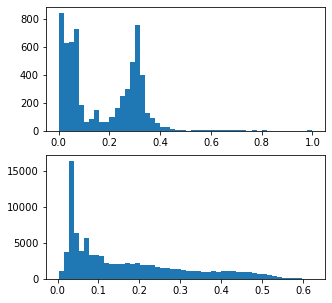

In [123]:
%%time
# columns histogrammed by %non-missing values
# rows histogrammed by %non-missing values

counts = BES_numeric.count()/BES_numeric.shape[0]
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
ax = axarr[0].hist(counts,bins=50)
ax = axarr[1].hist(counts_by_individuals,bins=50)

In [124]:
# In theory, this is picked on the basis of looking at the above two diagrams (really, the top one!)
# thresh = 0.33
# missing_value_thresh = 0.33
missing_value_thresh = 0.05

mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [125]:
# missing_value_thresh = 0.8

# mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
# mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [126]:
print(BES_numeric[mostly_filled_out].shape)
missing_fraction = BES_numeric[mostly_filled_out].isnull().sum().sum() / \
    (BES_numeric[mostly_filled_out].shape[0]*BES_numeric[mostly_filled_out].shape[1])
print(missing_fraction)

(92587, 4516)
0.7761683065178837


In [127]:
# %%time
# frac=.2
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).shape
# np.corrcoef( BES_numeric.sample(frac=frac).sample(frac=frac, axis=1) )
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).corr(min_periods=100, method='pearson')



In [128]:
memory_use(locs = locals().items())

                   BES_numeric: 741.9MiB
                     BES_Panel: 695.0MiB
           BES_reduced_with_na:  93.2MiB
                   BES_reduced:  24.0MiB
                      var_type:   5.6MiB
                      corr_mat:   3.4MiB
                            df:   1.7MiB
         counts_by_individuals:   1.4MiB
                  opts_per_cat: 659.3KiB
                        counts: 659.3KiB


In [129]:
%%time
# 0.05, 0.0025: 2.34
# 0.10, 0.01: 10.7s
# 0.10, spearman: 27s
# 0.10, kendall: 56s
# 0.15, 0.0225, pearson: 29s
# 0.20, 0.04, pearson: 65s
# 30 mins?
# W14_only: 55s
try:
    corr_mat = pd.read_msgpack(BES_data_folder+dataset_name+os.sep+"corr_df.msgpack")
except:
    corr_mat = BES_numeric.corr()
    corr_mat.to_msgpack(BES_data_folder+dataset_name+os.sep+"corr_df.msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\IPython\core\magics\execution.py:1310: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code, glob, local_ns)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  del sys.path[0]


Wall time: 2h 15min 58s


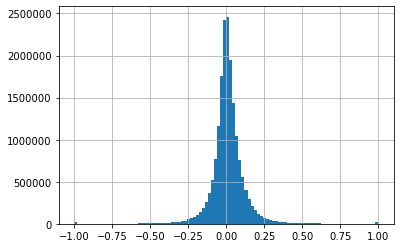

In [130]:
# %%time
## 5 minutes!
## 8h 41min 19s on W10_comb panel!

# data = BES_numeric
# corr_mat = BES_numeric.corr()

# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [131]:
# build a data frame of pairs of highly corr/anti-corr variables
# score on correlation, %non-missing values for each
# Building the high_corr_list is still **manual** (not much reason to automate)


corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])

id_num = 0

# min_filled_out = 0.02
min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out:
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1

corr_df

,var1,var2,corr,var1%,var2%,min var%
0,generalElectionVoteUnsqueezeW4,generalElectionVoteW4,1.0,0.222990,0.290991,0.222990
1,generalElectionVoteSqueezeW4,generalElectionVoteW4,1.0,0.068001,0.290991,0.068001
2,generalElectionVotePostW5,generalElectionVoteW5,1.0,0.033050,0.291866,0.033050
3,generalElectionVoteUnsqueezeW5,generalElectionVoteW5,1.0,0.207092,0.291866,0.207092
4,generalElectionVoteSqueezeW5,generalElectionVoteW5,1.0,0.051724,0.291866,0.051724
...,...,...,...,...,...,...
18564,small_mii_catW11,europeannessW12,-1.0,0.279089,0.093566,0.093566
18565,small_mii_catW11,econPersonalRetroW12,-1.0,0.279089,0.093523,0.093523
18566,small_mii_catW11,econGenRetroW12,-1.0,0.279089,0.090347,0.090347
18567,small_mii_catW11,immigSelfW12,-1.0,0.279089,0.089203,0.089203


In [132]:
# corr_df.to_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")


In [133]:
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,generalElectionVoteUnsqueezeW4,generalElectionVoteW4,1.0,0.222990,0.290991,0.222990
1,generalElectionVoteSqueezeW4,generalElectionVoteW4,1.0,0.068001,0.290991,0.068001
2,generalElectionVotePostW5,generalElectionVoteW5,1.0,0.033050,0.291866,0.033050
3,generalElectionVoteUnsqueezeW5,generalElectionVoteW5,1.0,0.207092,0.291866,0.207092
4,generalElectionVoteSqueezeW5,generalElectionVoteW5,1.0,0.051724,0.291866,0.051724
...,...,...,...,...,...,...
18564,small_mii_catW11,europeannessW12,-1.0,0.279089,0.093566,0.093566
18565,small_mii_catW11,econPersonalRetroW12,-1.0,0.279089,0.093523,0.093523
18566,small_mii_catW11,econGenRetroW12,-1.0,0.279089,0.090347,0.090347
18567,small_mii_catW11,immigSelfW12,-1.0,0.279089,0.089203,0.089203


In [134]:
# corr_df = pd.read_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")

In [135]:
corr_df.sort_values(by="min var%",ascending=False).head(70)

,var1,var2,corr,var1%,var2%,min var%
9451,Age,ageW16,0.994490,0.718805,0.409982,0.409982
9454,gor,gorW12,0.961492,0.720360,0.371478,0.371478
9358,ageW16,ageW12,0.998282,0.409982,0.371478,0.371478
9448,Age,ageW12,0.996027,0.718805,0.371478,0.371478
9402,pconW12,pconW8,0.956928,0.398598,0.362437,0.362437
...,...,...,...,...,...,...
6486,ageW12,ageW7,0.999704,0.371478,0.333686,0.333686
9421,gorW13,gorW15,0.973946,0.334658,0.333114,0.333114
7123,gorW15,gorW12,0.974397,0.333114,0.371478,0.333114
7124,gorW15,gorW14,0.984237,0.333114,0.335501,0.333114


In [136]:
corr_df[corr_df["min var%"]>missing_value_thresh]

,var1,var2,corr,var1%,var2%,min var%
0,generalElectionVoteUnsqueezeW4,generalElectionVoteW4,1.0,0.222990,0.290991,0.222990
1,generalElectionVoteSqueezeW4,generalElectionVoteW4,1.0,0.068001,0.290991,0.068001
3,generalElectionVoteUnsqueezeW5,generalElectionVoteW5,1.0,0.207092,0.291866,0.207092
4,generalElectionVoteSqueezeW5,generalElectionVoteW5,1.0,0.051724,0.291866,0.051724
5,generalElectionVoteUnsqueezeW11,generalElectionVoteW11,1.0,0.218800,0.279456,0.218800
...,...,...,...,...,...,...
18564,small_mii_catW11,europeannessW12,-1.0,0.279089,0.093566,0.093566
18565,small_mii_catW11,econPersonalRetroW12,-1.0,0.279089,0.093523,0.093523
18566,small_mii_catW11,econGenRetroW12,-1.0,0.279089,0.090347,0.090347
18567,small_mii_catW11,immigSelfW12,-1.0,0.279089,0.089203,0.089203


In [137]:
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,generalElectionVoteUnsqueezeW4,generalElectionVoteW4,1.0,0.222990,0.290991,0.222990
1,generalElectionVoteSqueezeW4,generalElectionVoteW4,1.0,0.068001,0.290991,0.068001
2,generalElectionVotePostW5,generalElectionVoteW5,1.0,0.033050,0.291866,0.033050
3,generalElectionVoteUnsqueezeW5,generalElectionVoteW5,1.0,0.207092,0.291866,0.207092
4,generalElectionVoteSqueezeW5,generalElectionVoteW5,1.0,0.051724,0.291866,0.051724
...,...,...,...,...,...,...
18564,small_mii_catW11,europeannessW12,-1.0,0.279089,0.093566,0.093566
18565,small_mii_catW11,econPersonalRetroW12,-1.0,0.279089,0.093523,0.093523
18566,small_mii_catW11,econGenRetroW12,-1.0,0.279089,0.090347,0.090347
18567,small_mii_catW11,immigSelfW12,-1.0,0.279089,0.089203,0.089203


In [152]:
np.linalg.matrix_rank(BES_imputed.values),BES_imputed.shape

(22, (92587, 6253))

In [153]:
# BES_imputed.columns[ BES_imputed.isnull().all() ]

In [154]:
high_corr_drop_list = []

for ind in corr_df.index:
    if corr_df.loc[ind]["var1%"] == corr_df.loc[ind]["var2%"]: # prefer age over ageGroup
        options = set(corr_df.loc[ind][["var1" , "var2"]].values)
        if 'age' in options:
#             print(ind, list(options.difference(['age']))[0] )
            high_corr_drop_list.append( list(options.difference(['age']))[0] )
    elif corr_df.loc[ind]["var1%"] < corr_df.loc[ind]["var2%"]:
#         print(ind, corr_df.loc[ind]["var1"])
        high_corr_drop_list.append( corr_df.loc[ind]["var1"] )
    else:
#         print(ind, corr_df.loc[ind]["var2"])
        high_corr_drop_list.append( corr_df.loc[ind]["var2"] )
    
high_corr_drop_list = list( set(high_corr_drop_list) ) # make unique
high_corr_drop_list

['labLookAfterJewsW15',
 'natSecurityGrnW4',
 'pcUnitedW6',
 'ptvSNPW9',
 'conPriorities_nhsW2',
 'eesEUIntegrationSelfW4',
 'redistSNPW6',
 'snpGovTrustW5',
 'devoResponsibleWalesWelfareW4',
 'proposalRetireW1',
 'grnToneW12',
 'reaskVoteW12',
 'labPriorities_crimeW1',
 'immigSelfW12',
 'ldPriorities_costLiveW3',
 'satDemWalesW4',
 'approveWelshGovtW4',
 'euID1W7',
 'eesEUIntegrationConW4',
 'successReduceInequalityGrnW12',
 'educationW11',
 'EUIntegrationConW1',
 'natSecurityLDW4',
 'pidRuinDayW7',
 'efficacyNotUnderstandW8',
 'snpFearW6',
 'accessFixComputerW3',
 'devoResponsibleScotNHSW6',
 'preferMPLGBTW6',
 'pidWeTheyW9',
 'pidWeTheyW7',
 'devoResponsibleScotSchoolsW6',
 'pcUnitedW12',
 'minIncomeWellOffW3',
 'scotIndepEconomyW11',
 'scotRefExpectationW2',
 'pidWeTheyW3',
 'mpRootsW4',
 'selfEUCertainW4',
 'satDemScotW11',
 'EUIntegrationSNPW7',
 'scotIndepEconomyW10',
 'selfRedistCertainW1',
 'eesEUIntegrationSNPW6',
 'effectsEUEconWalesW13',
 'welshnessW1',
 'likeSNPW1',
 'likeWoodW1',
 'devoPrefWalesW2',
 'cspl2W7',
 'scottishnessW9',
 'lrSNPW12',
 'handleMIIConW12',
 'referendumSettledW15',
 'riskPovertyW8',
 'blameScotUnion_milibandW3',
 'euID5W7',
 'londonSecondPostW8',
 'referendumContact_6W3',
 'immigSNPW16',
 'pconW7',
 'genElecTurnoutRetroW13',
 'minIncomeGetByW3',
 'devoResponsibleWalesTaxW6',
 'promiseHealthW1',
 'euID7W7',
 'integrityLucasW10',
 'likeDavidsonW14',
 'scottishnessW2',
 'satDemWalesW11',
 'eesEUIntegrationSNPW3',
 'devoPrefWalesW6',
 'expectationDevoScotW6',
 'tryReduceInequalityPCW4',
 'scottishnessW11',
 'pcToneW6',
 'partyContactLD_6W7',
 'labPriorities_schoolW2',
 'handleMIILDW9',
 'partyContactUKIPW1',
 'profile_religionW13',
 'likeWoodW13',
 'effectsEUEconScotW11',
 'euRefTurnoutRetroW14',
 'certaintyEUPCW8',
 'achieveReduceImmigSNPW10',
 'effectsEUEconWalesW16',
 'devoResponsibleWalesNHSW3',
 'satDemWalesW8',
 'responsibleImmigScottishGovtW4',
 'likeWoodW2',
 'pcFearW6',
 'EUIntegrationSelfW1',
 'labHandleNHSW3',
 'warmSpainW7',
 'scotRefID4W11',
 'euID6W8',
 'labPriorities_crimeW3',
 'certaintyEULDW4',
 'welshElectionVoteConstW6',
 'partyMemberNowW6',
 'econPersonalRetroW12',
 'accessFluentSpeakerW3',
 'devoResponsibleWalesJusticeW1',
 'EUIntegrationGreenW3',
 'snpLookAfterMCW10',
 'pcHopeW4',
 'conPriorities_immigW6',
 'eesEUIntegrationUKIPW4',
 'genElecTurnoutRetroW6',
 'snpLookAfterMCW12',
 'happyScotIndepResultW2',
 'ukipToneW12',
 'EUIntegrationConW3',
 'welshElectionVoteListW7',
 'ldPriorities2_econW4',
 'welshElectionVoteListW8',
 'devoResponsibleScotWelfareW3',
 'euRefVoteSqueezeW7',
 'devoResponsibleWalesSchoolsW4',
 'scotRefIDW10',
 'devoResponsibleWalesSchoolsW6',
 'ptvSNPW13',
 'scotRefID4W15',
 'eesEUIntegrationConW6',
 'immigManipCheck2W2',
 'labPriorities_noneW3',
 'referendumContact_1W3',
 'devoResponsibleScotSchoolsW10',
 'pidCommonPartyW9',
 'labHandleEconW1',
 'snpHopeW4',
 'scotIndepEconomyW15',
 'snpUnitedW12',
 'econGenProspW1',
 'responsibleNHSWelshGovtW4',
 'askVoteDiscuss3W12',
 'lrPCW3',
 'generalElectionVoteW6',
 'conPartnerSNPW4',
 'responsibleNHSWelshGovtW1',
 'scotIndepEconomyW1',
 'scotRefID7W11',
 'responsibleNHSScottishGovtW3',
 'eesEUIntegrationGreenW2',
 'immigSNPW7',
 'likeSturgeonW16',
 'labPartnerPCW4',
 'gorW3',
 'conPriorities_nhsW1',
 'londonAssemblyConstituencyW7',
 'labHandleNHSW1',
 'conPriorities_crimeW9',
 'responsibleEducationScotGovtW4',
 'ptvSNPW6',
 'minIncomeWellOffW2',
 'welshnessW9',
 'participation_4W8',
 'econGenProspW6',
 'welshTurnoutRetroW8',
 'govtHandleEducW4',
 'eesEUIntegrationLDW1',
 'scotReferendumIntentionW16',
 'goodTimePurchaseW8',
 'lrPCW6',
 'likeSNPW3',
 'partyContactSNPW7',
 'generalElectionVoteSqueezeW5',
 'devoResponsibleWalesSchoolsW1',
 'happyLeaveW7',
 'redistPCW2',
 'likeSNPW14',
 'EUIntegrationConW6',
 'resourceAccess1_5W7',
 'certaintyEUConW4',
 'pcUnitedW8',
 'referendumContact_3W3',
 'spendLeast3W3',
 'londonSecondW7',
 'certaintyEUGreenW4',
 'lrgreensW9',
 'likeUKIPW1',
 'conPriorities_schoolW1',
 'ptvSNPW

In [155]:
# high_corr_drop_list = []

In [156]:
# pref_list ['age','euRefVote',]


# high_corr_drop_list = []

# if ('age' in BES_numeric.columns) and ('Age' in BES_numeric.columns):
#     high_corr_drop_list.extend('Age')
    
# if ('ageGroup' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')
    
# if ('euRefVote' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')    

# high_corr_drop_list.extend(['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
#                        'ageGroup', 'voted2015', "ns_sec" , 'recallVote15'])
# # # 
# # high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
# #                        'ageGroup', 'Age', 'profile_turnout_2015', "ns_sec" , 'profile_past_vote_2015',"euIDW9"]

# # high_corr_drop_list = ["euID","ageGroup","euRefpastVote","voted2015"]

In [157]:
### HIGH CORR DROP LIST OVERRIDE
# high_corr_drop_list = []

Wall time: 1min 49s


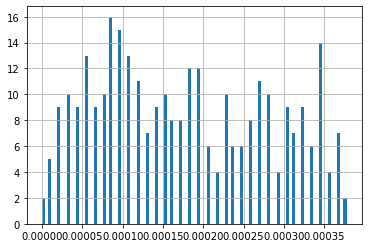

In [158]:
%%time
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

In [159]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars
# two_opt_cats
# many_cat_drop_list
# high_corr_drop_list
# mostly_not_filled_out
# mostly_filled_out

In [160]:
# very_low_var =[]

In [161]:
# mostly_not_filled_out =[]

In [162]:
# many_cat_drop_list =[]

In [163]:
gc.collect()

9452

In [164]:
# high_corr_drop_list = []

In [165]:
# high_corr_drop_list

In [166]:
high_corr_drop_list = []

In [167]:
# Time to dump some variables!
# (The results of this may have been exported back to the Imputation script
# if it looks like nothing is happening, that's why!)


BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

# # Wave 9 stuff
# BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
# print("W9_vars", BES_reduced.shape)
# drop_cols = cols.difference(BES_reduced.columns)
# if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
# cols = BES_reduced.columns

# Categorical variables with a huge number of categories
BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables which are redundant through very high correlation with other variables
BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too many' missing values
BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too low' variance
BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(92587, 6253)
many_cat_drop_list (92587, 6231)
high_corr_drop_list (92587, 6231)
mostly_not_filled_out (92587, 4494)
very_low_var (92587, 4484)
Index(['partyContactBrexit_1W16', 'partyContactCon_1W16',
       'partyContactCon_7W16', 'partyContactLD_7W16', 'partyContactLab_7W16',
       'partyContactNoneW14', 'partyContactNoneW3', 'partyContactNoneW4',
       'partyContactNoneW5', 'partyContactNoneW8'],
      dtype='object')


In [168]:
# necessary because some imputation types impute values outside of range of available values
# kind of suggests ... maybe not such good imputation methods??
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser

In [169]:
# problem
#  'xprofile_house_tenure': 'Own â\x80\x93 outright',

In [170]:
# reorder categories in a categorical variable so that the most numerous subcategory goes first
# so it can be dropped automatically when dummying
# also, return name of reference subcategory
def select_reference_subcategory(non_ordinal):
    order = BES_numeric[non_ordinal]\
        .dropna().astype('int').apply( lambda x: cat_dictionary[non_ordinal][x] ).value_counts().index
    return BES_reduced[non_ordinal].astype('category').cat.reorder_categories( order ), order[0]

In [171]:
# Recreate and rename categorical non_ordinal and ordinal variables:
# ordinal two categories -> one single dummy binary variable labelled with positive category name (e.g gender_female)
# ordinal 3+ category variables just renamed to append "__top_value" to variable name
# non-ordinal 3+ categories -> split to individual dummy binary variables "category_subcateory"

# need to create a dict of new_variable_names with old col names
# to allow reinsertion of missing values, say
new_old_col_names = dict()
# we need to drop one sub-category for each categorical variable we dummy
# advice supports obvious guess - always choose most numerous subcategory to the reference subcategory
non_ordinal_base_subcat = dict()


In [172]:
# NON-ORDINAL CATEGORICAL VARIABLES
# get split into one variable for each category
# NOTE: Dummy variable/multicollinearity trap
# we need to choose a base variable for each category and drop it!
drop_reference = False

non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    # return to text categories!
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])
    # reorder to place most numerous subcategory first
    BES_reduced[non_ordinal], non_ordinal_base_subcat[non_ordinal] = \
        select_reference_subcategory( non_ordinal  )
    
    # create dictionary so we have a record of which variable all newly generated ones come from!
    for subcat in cat_dictionary[non_ordinal]:
        new_col_name = non_ordinal + "_" + subcat
        new_old_col_names[new_col_name] = non_ordinal

if drop_reference == True:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=True ) 
else:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=False )
    

In [173]:
# BINARY CATEGORICAL VARIABLES
# get renamed with 'top' value separated by single underscore
# (this is the same as with non-ordinal variables - maybe use a different convention - like ___)
# i.e. haveDependents -> haveDependents_No

two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    
    new_col_name = col + "_" + cat_dictionary[col][1]
    new_old_col_names[new_col_name] = col
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )

In [174]:
# ORDINAL CATEGORICAL VARIABLES
# get renamed with 'top' value separated by double underscore
# i.e. likeBoris -> likeBoris__Strongly Agree

ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    new_old_col_names[new_col_name] = ordinal
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (92587, 7607)


In [175]:
gc.collect()

0

In [176]:
memory_use(locs = locals().items())

                   BES_numeric:   2.2GiB
                   BES_imputed:   2.2GiB
                   BES_reduced:   1.4GiB
                          _142: 741.9MiB
                     BES_Panel: 695.0MiB
                      corr_mat: 298.9MiB
                            df: 149.2MiB
           BES_reduced_with_na:  93.2MiB
                          mask:  37.3MiB
                      var_type:   5.6MiB


In [177]:
del BES_imputed

In [178]:
%%time
## slow! 2h 47min 41s

# 4h 19min 35s!!!?


## We should do correlation testing on a version with missing values
## and may also wish an output with missing values (e.g. to run weightedPCA on)
## Which means reinserting missing values

BES_reduced_with_na = BES_reduced.copy()

for col in BES_reduced_with_na.columns:
    if col in new_old_col_names.keys():
        old_col = new_old_col_names[col]
        null_series = BES_numeric[old_col].isnull()
    else:
        null_series = BES_numeric[col].isnull()
        
    BES_reduced_with_na.loc[null_series,col] = np.nan
    
    # 2 option ordinal (name change)
    # 3+ option ordinal (name change)
    # categorical (split into lots of variables)
    # other (no name change)

Wall time: 3h 10min 27s


In [179]:
# BES_reduced_with_na[col][~null_series]

In [180]:
## TEST CORRELATIONS
# we want to avoid having columns which are basically the same data
# through very high correlation/anti-correlation
# and when we find them, we want to keep the column with less missing values

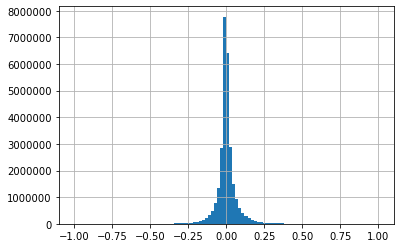

In [181]:
# data = BES_reduced_with_na
corr_mat = BES_reduced_with_na.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [182]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )    

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
('generalElectionCertaintyW5__Not at all certain', 'generalElectionCertaintyUnsqW5__Not at all certain', 1.0, 0.26000410424789655, 0.208441789884109)
('generalElectionCertaintyW5__Not at all certain', 'generalElectionCertaintySqW5__Not at all certain', 1.0, 0.26000410424789655, 0.051562314363787574)
('generalElectionCertaintyW12__Not at all certain', 'generalElectionCertaintyUnsqW12__Not at all certain', 1.0, 0.27428256666702666, 0.22846619935844126)
('ptvConW1__Very unlikely', 'likeConW1__Strongly like', 1.0, 0.15519457375225465, 0.1588667955544515)
('ptvConW1__Very unlikely', 'likeUKIPW1__Strongly like', 0.9999999999999998, 0.15519457375225465, 0.15342326676531262)
('eesEUIntegrationConW1__Unification should be pushed further', 'ptvLabW1__Very unlikely', 1.0, 0.1253199693261473, 0.1553781848423645)
('eesEUIntegrationConW1__Unification should b

('scotIndepMeBetterOffW2__Very unlikely', 'conUnitedW1__Very united', 1.0, 0.05862594100683681, 0.2178923606985862)
('scotIndepMeBetterOffW2__Very unlikely', 'ukipUnitedW1__Very united', 1.0, 0.05862594100683681, 0.19160357285580049)
('dv1w2W2__Very unsure', 'conUnitedW1__Very united', 1.0, 0.061358506053765645, 0.2178923606985862)
('dv1w2W2__Very unsure', 'ukipUnitedW1__Very united', 1.0, 0.061358506053765645, 0.19160357285580049)
('ldUnitedW2__Very united', 'expectationDevoScotW1__It will neither gain nor lose any powers', 1.0000000000000002, 0.21804356983161782, 0.055612558998563516)
('likeSalmondW3__Strongly like', 'econPersonalProspW1__Stay the same', 1.0, 0.055493751822610085, 0.05387365396869971)
('likeSalmondW3__Strongly like', 'econGenProspW1__Stay the same', 1.0, 0.055493751822610085, 0.05348483048376122)
('likeSalmondW3__Strongly like', 'govtHandleCostLiveW1__Very well', 1.0, 0.055493751822610085, 0.05286919329927527)
('likeSalmondW3__Strongly like', 'govtHandleEconW1__Very 

('expectationDevoScotW3__It will neither gain nor lose any powers', 'govtHandleLevelCrimeW1__Very well', 1.0, 0.051065484355255056, 0.05191873589164785)
('scotUnionEconomyW3__Very unlikely', 'govtHandleCostLiveW1__Very well', 1.0, 0.053560435050277036, 0.05286919329927527)
('scotUnionEconomyW3__Very unlikely', 'govtHandleEconW1__Very well', 1.0, 0.053560435050277036, 0.05293399721343169)
('scotUnionEconomyW3__Very unlikely', 'govtHandleImmigW1__Very well', 1.0, 0.053560435050277036, 0.05265318025208723)
('scotUnionEconomyW3__Very unlikely', 'govtHandleNHSW1__Very well', 1.0, 0.053560435050277036, 0.05275038612332185)
('scotUnionEconomyW3__Very unlikely', 'govtHandleEducW1__Very well', 1.0, 0.053560435050277036, 0.051087085659973865)
('scotUnionEconomyW3__Very unlikely', 'govtHandleLevelCrimeW1__Very well', 1.0, 0.053560435050277036, 0.05191873589164785)
('scotUnionMeBetterOffW3__Very unlikely', 'govtHandleCostLiveW1__Very well', 1.0, 0.05391685657813732, 0.05286919329927527)
('scotUnio

('natSecuritySelfW4__Protect civil liberties', 'likeLabW1__Strongly like', 1.0, 0.07093868469655568, 0.15884519424973267)
('natSecuritySelfW4__Protect civil liberties', 'likeGrnW1__Strongly like', 1.0, 0.07093868469655568, 0.15004266257681964)
('natSecuritySelfW4__Protect civil liberties', 'eesEUIntegrationSelfW1__Unification should be pushed further', 1.0, 0.07093868469655568, 0.1361206216855498)
('natSecuritySelfW4__Protect civil liberties', 'eesEUIntegrationLabW1__Unification should be pushed further', 1.0, 0.07093868469655568, 0.12119412012485554)
('natSecuritySelfW4__Protect civil liberties', 'eesEUIntegrationLDW1__Unification should be pushed further', 1.0, 0.07093868469655568, 0.12055688163565079)
('mpIndependentW4__7- Party loyalist', 'likeLDW1__Strongly like', 1.0, 0.05627139879248707, 0.15829436097940316)
('mpLocalNationalW4__7 - Focused on the constituency', 'likeConW1__Strongly like', 1.0, 0.05440288593431043, 0.1588667955544515)
('mpLocalNationalW4__7 - Focused on the cons

('preferMPDisabledW6__Slightly more', 'EUIntegrationLDW4__Unite fully with the European Union', 1.0, 0.06860574378692473, 0.12799853111127912)
('preferMPDisabledW6__Slightly more', 'EUIntegrationLDW6__Unite fully with the European Union', 0.9999999999999999, 0.06860574378692473, 0.12603281238186786)
('preferMPYoungW6__Slightly more', 'ptvConW1__Very unlikely', 0.9878291611472622, 0.070625465778133, 0.15519457375225465)
('preferMPYoungW6__Slightly more', 'ptvUKIPW1__Very unlikely', 1.0, 0.070625465778133, 0.15620983507403846)
('preferMPEthnicW6__Slightly more', 'ptvConW1__Very unlikely', 0.9878291611472622, 0.07101428926307149, 0.15519457375225465)
('preferMPEthnicW6__Slightly more', 'ptvUKIPW1__Very unlikely', 1.0, 0.07101428926307149, 0.15620983507403846)
('preferMPChristW6__Slightly more', 'EUIntegrationConW4__Unite fully with the European Union', 1.0, 0.05891755862054068, 0.13702787648373962)
('preferMPChristW6__Slightly more', 'EUIntegrationLabW4__Unite fully with the European Unio

('socialDistLabW7__Very unhappy', 'EUIntegrationUKIPW4__Unite fully with the European Union', 1.0, 0.07676023631827363, 0.14057049045762365)
('socialDistLabW7__Very unhappy', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07676023631827363, 0.13153034443280373)
('socialDistLabW7__Very unhappy', 'EUIntegrationLDW6__Unite fully with the European Union', 1.0, 0.07676023631827363, 0.12603281238186786)
('socialDistLDW7__Very unhappy', 'EUIntegrationConW4__Unite fully with the European Union', 1.0, 0.07636061218097573, 0.13702787648373962)
('socialDistLDW7__Very unhappy', 'EUIntegrationUKIPW4__Unite fully with the European Union', 1.0, 0.07636061218097573, 0.14057049045762365)
('socialDistLDW7__Very unhappy', 'EUIntegrationSelfW6__Unite fully with the European Union', 0.9878291611472619, 0.07636061218097573, 0.14613282642271594)
('socialDistLDW7__Very unhappy', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07636061218097573, 0.13153034443280373)
('socia

('warmGreeceW7__Very warm', 'EUIntegrationUKIPW4__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.14057049045762365)
('warmGreeceW7__Very warm', 'EUIntegrationSelfW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.14613282642271594)
('warmGreeceW7__Very warm', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.13153034443280373)
('warmGreeceW7__Very warm', 'EUIntegrationLDW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.12603281238186786)
('warmGreeceW7__Very warm', 'EUIntegrationUKIPW6__Unite fully with the European Union', 0.951189731211342, 0.07629580826681931, 0.1400412584920129)
('warmSpainW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', 1.0, 0.07696544871310228, 0.13299923315368248)
('warmSpainW7__Very warm', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07696544871310228, 0.13153034443280373)
('warmSpainW7__Very warm', 'EUIntegrationLDW6__Un

('antiIntellectualW8__Strongly agree', 'effectsEUImmigrationW7__Much lower', 0.9819805060619656, 0.09180554505492132, 0.304880814801214)
('antiIntellectualW8__Strongly agree', 'socialIdentityGlobalRemainW7__Nothing in common', 0.9819805060619659, 0.09180554505492132, 0.2581355913897199)
('antiIntellectualW8__Strongly agree', 'lrgreensW7__Right', 0.9795260923726159, 0.09180554505492132, 0.2391048419324527)
('antiIntellectualW8__Strongly agree', 'redistLDW7__Government should try to make incomes equal', 0.9798637100971994, 0.09180554505492132, 0.23063713048268114)
('antiIntellectualW8__Strongly agree', 'redistGreenW7__Government should try to make incomes equal', 0.9927777575601617, 0.09180554505492132, 0.20580643070841478)
('antiIntellectualW8__Strongly agree', 'asylumMoreW7__Many more', 0.9761870601839528, 0.09180554505492132, 0.3068897361400629)
('antiIntellectualW8__Strongly agree', 'immigLDW7__Allow many more', 1.0, 0.09180554505492132, 0.2309071467916662)
('antiIntellectualW8__Stro

('ptvConW8__Very unlikely', 'riskUnemploymentW7__Very unlikely', 1.0, 0.0904230615529178, 0.30304470390011556)
('ptvConW8__Very unlikely', 'childBenefitsRepatriateW7__Yes, the same amount as UK citizens', 0.9999999999999999, 0.0904230615529178, 0.3126788858047026)
('ptvConW8__Very unlikely', 'tuSupportW7__Mainly remain', 1.0, 0.0904230615529178, 0.2600581075096936)
('ptvConW8__Very unlikely', 'turkeyW7__Worse', 1.0, 0.0904230615529178, 0.2765939062719388)
('ptvConW8__Very unlikely', 'lrUKIPW7__Right', 1.0, 0.0904230615529178, 0.2567207059306382)
('ptvConW8__Very unlikely', 'redistConW7__Government should try to make incomes equal', 1.0, 0.0904230615529178, 0.25376132718416194)
('ptvLabW8__Very unlikely', 'partyIdStrengthW7__Very strong', 0.9683296637314885, 0.09052026742415242, 0.2847159968462095)
('ptvLabW8__Very unlikely', 'ethno5W7__Strongly agree', 0.9561828874675149, 0.09052026742415242, 0.31757158132351193)
('ptvLabW8__Very unlikely', 'likeCorbynW7__Strongly like', 0.974558628915

('handleMIILabW9__Very well', 'govtNatSecuritySuccessW4__Very unsuccessful', 1.0, 0.0654411526456198, 0.07855314460993444)
('handleMIILDW9__Very well', 'labHandleCostLiveW3__Very well', 1.0, 0.060051627118277946, 0.065419551340901)
('handleMIIUKIPW9__Very well', 'govtHandleEducW3__Very well', 1.0, 0.06490112002764967, 0.06738527007031225)
('handleMIIUKIPW9__Very well', 'labHandleCostLiveW3__Very well', 0.987829161147262, 0.06490112002764967, 0.065419551340901)
('handleMIIUKIPW9__Very well', 'mpIndependentW4__7- Party loyalist', 0.9958705948858224, 0.06490112002764967, 0.05627139879248707)
('handleMIIGrnW9__Very well', 'govtHandleCostLiveW3__Very well', 1.0, 0.05483491202868653, 0.07005303120308466)
('handleMIIGrnW9__Very well', 'govtHandleImmigW3__Very well', 1.0, 0.05483491202868653, 0.06970741032758379)
('handleMIIGrnW9__Very well', 'labHandleCostLiveW3__Very well', 1.0, 0.05483491202868653, 0.065419551340901)
('handleMIIGrnW9__Very well', 'EUIntegrationLDW4__Unite fully with the Eur

('euID1W12__Strongly disagree', 'cspl2W7__Usually acceptable', 1.0, 0.07072267164936762, 0.0757881776059274)
('euID1W12__Strongly disagree', 'cspl3W7__£7,500', 1.0, 0.07072267164936762, 0.05036344195189389)
('euID1W12__Strongly disagree', 'csplRank_1W7__Second most common reason', 1.0, 0.07072267164936762, 0.08382386296132287)
('euID2W12__Strongly disagree', 'happyLeaveW7__Very unhappy', 1.0, 0.07643621674749154, 0.07526974629267608)
('euID2W12__Strongly disagree', 'cspl2W7__Usually acceptable', 1.0, 0.07643621674749154, 0.0757881776059274)
('euID2W12__Strongly disagree', 'csplRank_1W7__Second most common reason', 1.0, 0.07643621674749154, 0.08382386296132287)
('euID7W12__Strongly disagree', 'certaintyEUUKIPW7__Very certain', 1.0, 0.06877855422467517, 0.06700724723773316)
('ptvConW12__Very unlikely', 'euScepticismW7__Work towards single European government', 1.0, 0.0865348267035329, 0.07327162560618661)
('ptvConW12__Very unlikely', 'natSecurityLDW7__Protect civil liberties', 1.0, 0.086

('britishnessW12__Very strongly British', 'econPersonalRetroW11__Stayed the same', 1.0, 0.09497013619622625, 0.3238143583872466)
('britishnessW12__Very strongly British', 'econGenRetroW11__Stayed the same', 1.0, 0.09497013619622625, 0.315184637152084)
('britishnessW12__Very strongly British', 'redistSelfW11__Government should try to make incomes equal', 1.0, 0.09497013619622625, 0.28926307148951796)
('britishnessW12__Very strongly British', 'redistLabW11__Government should try to make incomes equal', 1.0, 0.09497013619622625, 0.2548413924201022)
('britishnessW12__Very strongly British', 'antiIntellectualW11__Strongly agree', 1.0, 0.09497013619622625, 0.3171611565338546)
('britishnessW12__Very strongly British', 'efficacyUnderstandW11__Strongly agree', 1.0, 0.09497013619622625, 0.32418158056746627)
('britishnessW12__Very strongly British', 'efficacyVoteEffortW11__Strongly agree', 1.0, 0.09497013619622625, 0.32667653126248825)
('britishnessW12__Very strongly British', 'radicalW11__Strong

('englishnessW12__Very strongly English', 'controlImmigW11__Some control', 1.0, 0.09468931923488179, 0.30471880501582294)
('englishnessW12__Very strongly English', 'euPriorityBalanceW11__Control immigration', 1.0, 0.09468931923488179, 0.2975687731538985)
('englishnessW12__Very strongly English', 'effectsEUImmigrationW11__Much lower', 1.0, 0.09468931923488179, 0.3082938209467852)
('englishnessW12__Very strongly English', 'effectsEUNHSW11__Worse', 1.0, 0.09468931923488179, 0.30340112542797587)
('englishnessW12__Very strongly English', 'UKsovereigntyPostW11__Much more likely', 1.0, 0.09468931923488179, 0.29605668182358214)
('englishnessW12__Very strongly English', 'immigEconW11__Good for economy', 1.0, 0.09468931923488179, 0.3130677092896411)
('englishnessW12__Very strongly English', 'immigSelfW11__Allow many more', 1.0, 0.09468931923488179, 0.3014246060462052)
('englishnessW12__Very strongly English', 'changeEconomyW11__Staying about the same', 1.0, 0.09468931923488179, 0.315022627366692

('econPersonalRetroW12__Stayed the same', 'happyEULeaveW11__Extremely happy', 1.0, 0.09352284878006632, 0.32624450516811215)
('econPersonalRetroW12__Stayed the same', 'goodConductEURefW11__Expected 20xx election to be conducted fairly', 1.0, 0.09352284878006632, 0.3108211735988854)
('econPersonalRetroW12__Stayed the same', 'expectGoodConductGeneralW11__Expected 20xx election to be conducted fairly', 1.0, 0.09352284878006632, 0.29998811928240465)
('econPersonalRetroW12__Stayed the same', 'polAttentionW11__Pay no attention', 1.0, 0.09352284878006632, 0.3302947498028881)
('econPersonalRetroW12__Stayed the same', 'winConstituencyLabW11__98.0', 1.0, 0.09352284878006632, 0.3051184291531209)
('econPersonalRetroW12__Stayed the same', 'electionInterestW11__Very interested', 1.0, 0.09352284878006632, 0.3272381651851772)
('econPersonalRetroW12__Stayed the same', 'europeannessW11__Very strongly European', 1.0, 0.09352284878006632, 0.3261148973397993)
('econPersonalRetroW12__Stayed the same', 'like

('econGenRetroW12__Stayed the same', 'changeEducationW11__Staying about the same', 1.0, 0.09034745698640198, 0.30027973689610854)
('econGenRetroW12__Stayed the same', 'changeImmigW11__Staying about the same', 1.0, 0.09034745698640198, 0.3064577100456868)
('econGenRetroW12__Stayed the same', 'wcEconW11__Stayed the same', 1.0, 0.09034745698640198, 0.28998671519759794)
('econGenRetroW12__Stayed the same', 'prefTradeoffW11__Strongly agree', 1.0, 0.09034745698640198, 0.31062676185641613)
('econGenRetroW12__Stayed the same', 'howToReduceDeficitW11__Only by increasing taxes', 1.0, 0.09034745698640198, 0.2823830559365786)
('econGenRetroW12__Stayed the same', 'warmWhiteW11__Very warm', 1.0, 0.09034745698640198, 0.30885545486947413)
('econGenRetroW12__Stayed the same', 'warmAsianW11__Very warm', 1.0, 0.09034745698640198, 0.30510762850076145)
('econGenRetroW12__Stayed the same', 'warmBlackW11__Very warm', 1.0, 0.09034745698640198, 0.3056692624234504)
('overseasAidW12__Strongly agree', 'winConstit

('immigSelfW12__Allow many more', 'likeBlairW11__Strongly like', 1.0, 0.08920258783630532, 0.31789560089429403)
('immigSelfW12__Allow many more', 'likeFarageW11__Strongly like', 1.0, 0.08920258783630532, 0.3185544406882176)
('immigSelfW12__Allow many more', 'majorityPartyLabW11__Very unlikely', 1.0, 0.08920258783630532, 0.2945445904932658)
('immigSelfW12__Allow many more', 'likeLabW11__Strongly like', 1.0, 0.08920258783630532, 0.31380215365008046)
('immigSelfW12__Allow many more', 'labUnitedW11__Very united', 1.0, 0.08920258783630532, 0.297849590115243)
('immigSelfW12__Allow many more', 'riskPovertyW11__Very unlikely', 1.0, 0.08920258783630532, 0.31803600937496623)
('immigSelfW12__Allow many more', 'redistConW11__Government should try to make incomes equal', 1.0, 0.08920258783630532, 0.25479818981066454)
('immigSelfW12__Allow many more', 'efficacyNotUnderstandW11__Strongly agree', 1.0, 0.08920258783630532, 0.32629850842990915)
('immigSelfW12__Allow many more', 'efficacyPolCareW11__Stro

('competentMayW13__No competence at all', 'euID3W8__Strongly disagree', 1.0, 0.15536738419000506, 0.05326881743657317)
('competentMayW13__No competence at all', 'euID5W8__Strongly disagree', 1.0, 0.15536738419000506, 0.05214554959119531)
('ageW13', 'ageW1', 0.9964555557314937, 0.3362891118623565, 0.3281886225928046)
('ageW13', 'ageW7', 0.9995398545675799, 0.3362891118623565, 0.33368615464374046)
('ageW13', 'ageW8', 0.9998535592098361, 0.3362891118623565, 0.3618434553447028)
('ageW13', 'ageW9', 0.9999216083674396, 0.3362891118623565, 0.32440839426701373)
('ageW13', 'ageW11', 0.9994979078556573, 0.3362891118623565, 0.334344994437664)
('ageW13', 'ageW12', 0.9998164854560413, 0.3362891118623565, 0.37147763724928984)
('ageW14', 'ageW1', 0.9967563285070296, 0.3355006642401201, 0.3281886225928046)
('ageW14', 'ageW7', 0.9996024780654461, 0.3355006642401201, 0.33368615464374046)
('ageW14', 'ageW8', 0.9995515992568986, 0.3355006642401201, 0.3618434553447028)
('ageW14', 'ageW9', 0.999370802067204

('generalElectionVoteUnsqueezeW5_Labour', 'generalElectionVoteUnsqueezeW4_Labour', 0.9593545342970685, 0.2070917083391837, 0.22299026861222418)
('generalElectionVoteUnsqueezeW5_Labour', 'generalElectionVoteW5_Labour', 1.0, 0.2070917083391837, 0.291866028708134)
('generalElectionVoteUnsqueezeW5_Conservative', 'generalElectionVoteUnsqueezeW4_Conservative', 0.9542561050679971, 0.2070917083391837, 0.22299026861222418)
('generalElectionVoteUnsqueezeW5_Conservative', 'generalElectionVoteW5_Conservative', 1.0, 0.2070917083391837, 0.291866028708134)
('generalElectionVoteUnsqueezeW5_United Kingdom Independence Party (UKIP)', 'generalElectionVoteW5_United Kingdom Independence Party (UKIP)', 1.0, 0.2070917083391837, 0.291866028708134)
('generalElectionVoteUnsqueezeW5_Scottish National Party (SNP)', 'generalElectionVoteW4_Scottish National Party (SNP)', 0.9706617644707386, 0.2070917083391837, 0.2909911758670224)
('generalElectionVoteUnsqueezeW5_Scottish National Party (SNP)', 'generalElectionVoteU

('generalElectionVoteW13_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW11_Scottish National Party (SNP)', 0.9501851052168311, 0.29992331536824823, 0.218799615496776)
('generalElectionVoteW13_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9605304502136439, 0.29992331536824823, 0.22736453281778218)
('generalElectionVoteW14_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9525027831811435, 0.25782237247129725, 0.22736453281778218)
('generalElectionVoteW15_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW11_Scottish National Party (SNP)', 0.9550867988826282, 0.21711471372870922, 0.218799615496776)
('generalElectionVoteW15_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9519704619268536, 0.21711471372870922, 0.22736453281778218)
('generalElectionVoteTIGW15_Conservative', 'generalElectionVoteW15_Conservative', 0.

('educationW4_Scottish Higher Certificate', 'educationW3_Scottish Higher Certificate', 0.9536215180080243, 0.3299275276226684, 0.2927840841586832)
('educationW4_Nursing qualification (eg SEN, SRN, SCM, RGN)', 'educationW3_Nursing qualification (eg SEN, SRN, SCM, RGN)', 0.9541308658466474, 0.3299275276226684, 0.2927840841586832)
('ashcroftW5_Labour', 'generalElectionVoteUnsqueezeW5_Labour', 0.9571839177767906, 0.27826800738764623, 0.2070917083391837)
('ashcroftW5_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW4_Scottish National Party (SNP)', 0.9648976394061999, 0.27826800738764623, 0.22299026861222418)
('ashcroftW5_Scottish National Party (SNP)', 'generalElectionVoteW5_Scottish National Party (SNP)', 0.974317372299947, 0.27826800738764623, 0.291866028708134)
('ashcroftW5_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW5_Scottish National Party (SNP)', 0.9809882179027953, 0.27826800738764623, 0.2070917083391837)
('ashcroftW5_Scottish National Party (SNP)', '

('educationW8W9W10_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW7_University or CNAA higher degree (eg M.Sc, Ph.D)', 0.969308362534297, 0.4540162225798438, 0.32234546966636785)
('educationW8W9W10_No formal qualifications', 'educationW7_No formal qualifications', 0.9530004688674732, 0.4540162225798438, 0.32234546966636785)
('educationW8W9W10_Nursing qualification (eg SEN, SRN, SCM, RGN)', 'educationW7_Nursing qualification (eg SEN, SRN, SCM, RGN)', 0.9592078447262057, 0.4540162225798438, 0.32234546966636785)
('educationW9_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW7_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9576682065364543, 0.314190977135019, 0.32234546966636785)
('educationW9_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW8W9W10_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9672918022463953, 0.314190977135019, 0.4540162225798438)
('educationW9_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW

('educationW12_Clerical and commercial', 'educationW11_Clerical and commercial', 0.9543485111875272, 0.3591324916024928, 0.3234147342499487)
('educationW12_Nursing qualification (eg SEN, SRN, SCM, RGN)', 'educationW11_Nursing qualification (eg SEN, SRN, SCM, RGN)', 0.9844484827312096, 0.3591324916024928, 0.3234147342499487)
('educationW12_onc', 'educationW11_onc', 0.9718568345090103, 0.3591324916024928, 0.3234147342499487)
('educationW12_Scottish Ordinary/ Lower Certificate', 'educationW11_Scottish Ordinary/ Lower Certificate', 0.9862193051139228, 0.3591324916024928, 0.3234147342499487)
('educationW12_Youth training certificate/skillseekers', 'educationW11_Youth training certificate/skillseekers', 0.9763470403352151, 0.3591324916024928, 0.3234147342499487)
('gorW12_South East', 'gorW11_South East', 0.9931809117480945, 0.37147763724928984, 0.334344994437664)
('gorW12_Scotland', 'country_Scotland', 0.9818753633211638, 0.37147763724928984, 0.7203495091103502)
('gorW12_Scotland', 'gorW11_S

('gorW14_West Midlands', 'gorW12_West Midlands', 0.9859871371523993, 0.3355006642401201, 0.37147763724928984)
('gorW14_East Midlands', 'gorW11_East Midlands', 0.9797197132742489, 0.3355006642401201, 0.334344994437664)
('gorW14_East Midlands', 'gorW12_East Midlands', 0.983827676889615, 0.3355006642401201, 0.37147763724928984)
('gorW14_Wales', 'country_Wales', 0.9677631824907842, 0.3355006642401201, 0.7203495091103502)
('gorW14_Wales', 'gorW11_Wales', 0.9911182668356867, 0.3355006642401201, 0.334344994437664)
('gorW14_Wales', 'gorW12_Wales', 0.9908335774290074, 0.3355006642401201, 0.37147763724928984)
('gorW14_North East', 'gorW11_North East', 0.9907159497125895, 0.3355006642401201, 0.334344994437664)
('gorW14_North East', 'gorW12_North East', 0.9904095200070328, 0.3355006642401201, 0.37147763724928984)
('localElectionVoteW14_Liberal Democrat', 'spendMost3W3_Infrastructure: Roads and Public Transport', 1.0, 0.09207556136390638, 0.05273958547096245)
('localElectionVoteW14_Liberal Democrat

('subjectHEW15_Humanities, social sciences, psychology or education', 'redistConW1__Government should try to make incomes equal', 1.0, 0.07494572672189401, 0.2587512285742059)
('subjectHEW15_Humanities, social sciences, psychology or education', 'redistUKIPW1__Government should try to make incomes equal', 1.0, 0.07494572672189401, 0.21049391383239546)
('subjectHEW15_Humanities, social sciences, psychology or education', 'generalElectionVoteW1_Labour', 1.0, 0.07494572672189401, 0.2589780422737533)
('subjectHEW15_Humanities, social sciences, psychology or education', 'partyIdW1_No - none', 1.0, 0.07494572672189401, 0.30490241610593277)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'generalElectionCertaintyW1__Not at all certain', 1.0, 0.07494572672189401, 0.26119217600743083)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'likeGrnW1__Strongly like', 1.0, 0.07494572672189401, 0.15004266257681964)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 

('localElectionVoteW16_Green Party', 'scotElectionVoteListW6_Scottish National Party (SNP)', 1.0, 0.10901098426344952, 0.05217795154827352)
('workingStatusW16_Retired', 'workingStatusW15_Retired', 0.9592265604774782, 0.3967403631179323, 0.21825958287880587)
('educationW16_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW15_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9716042237738016, 0.3918152656420448, 0.3202393424562844)
('educationW16_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW15_University or CNAA higher degree (eg M.Sc, Ph.D)', 0.9691016539344978, 0.3918152656420448, 0.3202393424562844)
('educationW16_No formal qualifications', 'educationW15_No formal qualifications', 0.9608460958069373, 0.3918152656420448, 0.3202393424562844)
('ns_sec_analyticW16_Employers in large organisations and higher managerial', 'ns_secW16_Higher managerial and administrative occupations', 0.9594268286052968, 0.32473241383779583, 0.32473241383779583)
('miilabe

('gorW13_East Midlands', 'gorW15_East Midlands', 0.9721624246316314, 0.3346582133560867, 0.33311372006869217)
('gorW13_East Midlands', 'gorW16_East Midlands', 0.9649444162725099, 0.3346582133560867, 0.40998196291055977)
('gorW13_Wales', 'country_Wales', 0.9728402879771448, 0.3346582133560867, 0.7203495091103502)
('gorW13_Wales', 'gorW11_Wales', 0.9990421972083027, 0.3346582133560867, 0.334344994437664)
('gorW13_Wales', 'gorW12_Wales', 0.999421459000913, 0.3346582133560867, 0.37147763724928984)
('gorW13_Wales', 'gorW14_Wales', 0.9895575921916305, 0.3346582133560867, 0.3355006642401201)
('gorW13_Wales', 'gorW15_Wales', 0.9817149770999356, 0.3346582133560867, 0.33311372006869217)
('gorW13_Wales', 'gorW16_Wales', 0.9818544841734953, 0.3346582133560867, 0.40998196291055977)
('gorW13_North East', 'gorW11_North East', 0.996049118063365, 0.3346582133560867, 0.334344994437664)
('gorW13_North East', 'gorW12_North East', 0.9995244181308042, 0.3346582133560867, 0.37147763724928984)
('gorW13_North 

('gorW3_North West', 'gorW11_North West', 0.9687053926300843, 0.30065775972868763, 0.334344994437664)
('gorW3_North West', 'gorW12_North West', 0.9684580262614008, 0.30065775972868763, 0.37147763724928984)
('gorW3_North West', 'gorW14_North West', 0.9605264366239685, 0.30065775972868763, 0.3355006642401201)
('gorW3_North West', 'gorW15_North West', 0.9551883261992705, 0.30065775972868763, 0.33311372006869217)
('gorW3_North West', 'gorW16_North West', 0.9532189467794737, 0.30065775972868763, 0.40998196291055977)
('gorW3_North West', 'gorW13_North West', 0.9700389066820487, 0.30065775972868763, 0.3346582133560867)
('gorW3_North West', 'gorW2_North West', 0.9901627103177099, 0.30065775972868763, 0.32906347543391623)
('gorW3_East of England', 'gorW2_East of England', 0.9859699389741416, 0.30065775972868763, 0.32906347543391623)
('gorW3_South West', 'gorW11_South West', 0.9515886098360041, 0.30065775972868763, 0.334344994437664)
('gorW3_South West', 'gorW12_South West', 0.9516127836242216, 

('gorW6_South West', 'gorW12_South West', 0.9645386811500579, 0.3087150463888019, 0.37147763724928984)
('gorW6_South West', 'gorW14_South West', 0.9558255599919921, 0.3087150463888019, 0.3355006642401201)
('gorW6_South West', 'gorW13_South West', 0.9650243664149215, 0.3087150463888019, 0.3346582133560867)
('gorW6_South West', 'gorW2_South West', 0.9757407762691345, 0.3087150463888019, 0.32906347543391623)
('gorW6_South West', 'gorW3_South West', 0.979837011091651, 0.3087150463888019, 0.30065775972868763)
('gorW6_Yorkshire and the Humber', 'gorW11_Yorkshire and the Humber', 0.9807477716765469, 0.3087150463888019, 0.334344994437664)
('gorW6_Yorkshire and the Humber', 'gorW12_Yorkshire and the Humber', 0.9729146249527209, 0.3087150463888019, 0.37147763724928984)
('gorW6_Yorkshire and the Humber', 'gorW14_Yorkshire and the Humber', 0.9700954246151212, 0.3087150463888019, 0.3355006642401201)
('gorW6_Yorkshire and the Humber', 'gorW15_Yorkshire and the Humber', 0.9604102502360569, 0.30871504

('gor_Wales', 'gorW11_Wales', 0.9740281167403222, 0.7203603097627097, 0.334344994437664)
('gor_Wales', 'gorW12_Wales', 0.9743382411181907, 0.7203603097627097, 0.37147763724928984)
('gor_Wales', 'gorW14_Wales', 0.9677631824907842, 0.7203603097627097, 0.3355006642401201)
('gor_Wales', 'gorW15_Wales', 0.9592705522103794, 0.7203603097627097, 0.33311372006869217)
('gor_Wales', 'gorW16_Wales', 0.9608842504281871, 0.7203603097627097, 0.40998196291055977)
('gor_Wales', 'gorW13_Wales', 0.9728402879771448, 0.7203603097627097, 0.3346582133560867)
('gor_Wales', 'gorW2_Wales', 0.9942093876294549, 0.7203603097627097, 0.32906347543391623)
('gor_Wales', 'gorW3_Wales', 0.9896647832258189, 0.7203603097627097, 0.30065775972868763)
('gor_Wales', 'gorW6_Wales', 0.9812730643791836, 0.7203603097627097, 0.3087150463888019)
('gor_Yorkshire and the Humber', 'gorW11_Yorkshire and the Humber', 0.9722045256257041, 0.7203603097627097, 0.334344994437664)
('gor_Yorkshire and the Humber', 'gorW12_Yorkshire and the Hum

('profile_house_tenureW11_Rent - from a private landlord', 'profile_house_tenureW10_Rent from a private landlord', 0.9608160820691886, 0.32182703835311655, 0.3209413848596455)
('profile_house_tenureW11_Rent - from a housing association', 'profile_house_tenureW10_Rent from a housing association', 0.9523082110733587, 0.32182703835311655, 0.3209413848596455)
('profile_house_tenureW11_Rent - from my local authority', 'profile_house_tenureW10_Rent from my local authority', 0.9539455659082642, 0.32182703835311655, 0.3209413848596455)
('profile_newspaperW11_None', 'europeannessW12__Very strongly European', 1.0, 0.334344994437664, 0.09356605138950393)
('profile_newspaperW11_None', 'econPersonalRetroW12__Stayed the same', 1.0, 0.334344994437664, 0.09352284878006632)
('profile_newspaperW11_None', 'econGenRetroW12__Stayed the same', 1.0, 0.334344994437664, 0.09034745698640198)
('profile_newspaperW11_None', 'immigSelfW12__Allow many more', 1.0, 0.334344994437664, 0.08920258783630532)
('profile_new

('profile_marital_statW13_Widowed', 'profile_marital_statW11_Widowed', 0.9938775241013699, 0.3362891118623565, 0.334344994437664)
('profile_marital_statW13_Separated (after being married)', 'profile_marital_statW11_Separated (after being married)', 0.9849843100491867, 0.3362891118623565, 0.334344994437664)
('profile_marital_statW13_Civil Partnership', 'profile_marital_statW11_Civil Partnership', 0.9662483644492982, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_None', 'profile_newspaperW11_None', 0.9540538706761482, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Daily Mail / The Scottish Daily Mail', 'profile_newspaperW11_The Daily Mail / The Scottish Daily Mail', 0.957748279840388, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Guardian', 'profile_newspaperW11_The Guardian', 0.9615234792008271, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Sun', 'profile_newspaperW11_The Sun', 0.9549100698044753, 0.33628911186235

('profile_religionW13_Yes - Presbyterian/Church of Scotland', 'profile_religionW11_Yes - Presbyterian/Church of Scotland', 0.9926841028438218, 0.3222806657522114, 0.3160270880361174)
('profile_religionW13_Yes - Presbyterian/Church of Scotland', 'profile_religionW12_Yes - Presbyterian/Church of Scotland', 0.9920790902416925, 0.3222806657522114, 0.3504487671055332)
('profile_religionW13_Yes - Methodist', 'profile_religionW11_Yes - Methodist', 0.9857372930399426, 0.3222806657522114, 0.3160270880361174)
('profile_religionW13_Yes - Methodist', 'profile_religionW12_Yes - Methodist', 0.9967192147675384, 0.3222806657522114, 0.3504487671055332)
('profile_religionW13_Yes - Other', 'profile_religionW11_Yes - Other', 0.9710730254697271, 0.3222806657522114, 0.3160270880361174)
('profile_religionW13_Yes - Other', 'profile_religionW12_Yes - Other', 0.9878364570599366, 0.3222806657522114, 0.3504487671055332)
('profile_religionW13_Yes - Baptist', 'profile_religionW11_Yes - Baptist', 0.9841099867620337,

('profile_marital_statW16_Married', 'profile_marital_statW15_Married', 0.9971083703714793, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Never married', 'profile_marital_statW15_Never married', 0.9922261870073967, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Living as married', 'profile_marital_statW15_Living as married', 0.9884066940143477, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Divorced', 'profile_marital_statW15_Divorced', 0.9889046755192837, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Widowed', 'profile_marital_statW15_Widowed', 0.9911391966965806, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Separated (after being married)', 'profile_marital_statW15_Separated (after being married)', 0.9774982498205271, 0.40983075377752815, 0.3330597168068951)
('profile_religionW16_No, I do not regard myself as belonging to any particular religion.', 'profile_religionW15_No, I do not 

('scotRefTurnoutW3_W14_Yes, I voted', 'scotReferendumRetroW3_Yes, I voted', 1.0, 0.08511994124445116, 0.05666022227742556)
('scotRefTurnoutW3_W14_No, I was not eligible to vote', 'scotReferendumRetroW3_No, I was not eligible to vote', 1.0, 0.08511994124445116, 0.05666022227742556)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleCostLiveW1__Very well', 1.0, 0.08511994124445116, 0.05286919329927527)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleEconW1__Very well', 1.0, 0.08511994124445116, 0.05293399721343169)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleImmigW1__Very well', 1.0, 0.08511994124445116, 0.05265318025208723)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleNHSW1__Very well', 1.0, 0.08511994124445116, 0.05275038612332185)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleEducW1__Very well', 1.0, 0.08511994124445116, 0.051087085659973865)
('scotRefTurnoutW3_W14_No, I did not vote', 'govtHandleLevelCrimeW1__Very well', 1.0, 0.085119941244451

('mii_catW3_environment', 'miilabelW3_environment', 0.9503420078410325, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_unemployment', 'miilabelW3_unemployment', 0.9581030355120206, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_europe', 'miilabelW3_europe', 0.9688721640602119, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_housing', 'miilabelW3_housing', 0.9881069854522212, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_education', 'miilabelW3_education', 0.9880401098131495, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_taxation', 'miilabelW3_taxation', 0.9540372848276523, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_inflation', 'miilabelW3_inflation', 0.9733029676934147, 0.2618510158013544, 0.2110123451456468)
('LRAL_mii_catW7_Lib-auth', 'ptvLDW8__Very unlikely', 0.9901475429766744, 0.2925356691544169, 0.08972101914955663)
('LRAL_mii_catW3_General-negativity', 'miilabelW3_politics-neg', 0.951717845934559, 0.2411569658807392, 0.2110123451456468)
('small

('small_mii_catW6_Terrorism', 'miilabelW6_terrorism', 0.9900604959515096, 0.28096817047749684, 0.2399364921641267)
('small_mii_catW6_Terrorism', 'mii_catW6_terrorism', 1.0, 0.28096817047749684, 0.29234125741194766)
('small_mii_catW11_Europe', 'europeannessW12__Very strongly European', 1.0, 0.2790888569669608, 0.09356605138950393)
('small_mii_catW11_Europe', 'econPersonalRetroW12__Stayed the same', 1.0, 0.2790888569669608, 0.09352284878006632)
('small_mii_catW11_Europe', 'econGenRetroW12__Stayed the same', 1.0, 0.2790888569669608, 0.09034745698640198)
('small_mii_catW11_Europe', 'immigSelfW12__Allow many more', 1.0, 0.2790888569669608, 0.08920258783630532)
('small_mii_catW11_Europe', 'immigLabW12__Allow many more', 1.0, 0.2790888569669608, 0.07787270351129208)
('small_mii_catW11_Europe', 'mii_catW11_europe', 1.0, 0.2790888569669608, 0.2979143940293994)
('small_mii_catW11_Immigration', 'britishnessW12__Very strongly British', 1.0, 0.2790888569669608, 0.09497013619622625)
('small_mii_catW

('ldPriorities2_costLiveW4_Yes', 'eesEUIntegrationLDW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12055688163565079)
('ldPriorities2_nhsW4_Yes', 'likeConW1__Strongly like', 1.0, 0.05420847419184119, 0.1588667955544515)
('ldPriorities2_nhsW4_Yes', 'likeLabW1__Strongly like', 1.0, 0.05420847419184119, 0.15884519424973267)
('ldPriorities2_nhsW4_Yes', 'likeGrnW1__Strongly like', 1.0, 0.05420847419184119, 0.15004266257681964)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationSelfW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.1361206216855498)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationLabW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12119412012485554)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationLDW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12055688163565079)
('ldPriorities2_crimeW4_Yes', 'likeConW1__Strongly like', 1.0, 0.05420847419184119, 0.1588667955544515)
('ldPriorities2_crimeW4_Yes', 'li

('euRefVoteUnsqueezeW7_Stay/remain in the EU', 'euIDW7_The remain side', 0.9633101369156244, 0.28273947746443884, 0.07048505729746077)
('devoResponsibleScotWelfareW4_The UK Parliament', "mpVotePartySelfW15_MP should vote according to their party's opinion", 1.0, 0.05575296747923575, 0.057481071856740146)
('devoResponsibleScotNHSW4_The UK Parliament', 'localElectionVoteW14_United Kingdom Independence Party (UKIP)', 1.0, 0.055968980526423795, 0.09207556136390638)
('devoResponsibleScotSchoolsW4_The UK Parliament', 'localElectionVoteW14_United Kingdom Independence Party (UKIP)', 1.0, 0.05574216682687634, 0.09207556136390638)
('devoResponsibleScotSchoolsW4_The UK Parliament', 'noDealEmotions_4W15_Yes', 1.0, 0.05574216682687634, 0.06919977966669187)
('devoResponsibleScotPoliceW4_The UK Parliament', 'noDealEmotions_4W15_Yes', 1.0, 0.05565576160800113, 0.06919977966669187)
('referendumSettledW4_Yes', 'localElectionVoteW2_Labour', 1.0, 0.0546837028956549, 0.08372665709008824)
('ukipPriorities_c

('prPreferenceW9_That one party get more than half the seats in parliament so it can govern on its own', 'EUIntegrationLDW4__Unite fully with the European Union', 0.9958705948858224, 0.06445829328091417, 0.12799853111127912)
('labPriorities_crimeW3_Yes', 'handleMIILDW7__Very well', 1.0, 0.05873394753043084, 0.060451251255575836)
('labPriorities_crimeW3_Yes', 'handleMIIGrnW7__Very well', 0.9948497511671096, 0.05873394753043084, 0.05414367027768477)
('labPriorities_crimeW3_Yes', 'socialDistLDW7__Very unhappy', 0.9682458365518541, 0.05873394753043084, 0.07636061218097573)
('labPriorities_crimeW3_Yes', 'riskUnemploymentW8__Very unlikely', 1.0, 0.05873394753043084, 0.0611640943112964)
('labPriorities_crimeW3_Yes', 'euID3W8__Strongly disagree', 1.0, 0.05873394753043084, 0.05326881743657317)
('conPriorities_nhsW9_Yes', 'csplUncoverWrongsW2__Very confident', 1.0, 0.06775249225053193, 0.05539654595137546)
('conPriorities_costLiveW9_Yes', 'eesEUIntegrationLDW4__Unification should be pushed furth

('euRefVoteW7_Stay/remain in the EU', 'euIDW7_The remain side', 0.9576912867703157, 0.30289349476708394, 0.07048505729746077)
('euRefVoteW7_Stay/remain in the EU', 'euRefVoteUnsqueezeW7_Stay/remain in the EU', 1.0, 0.30289349476708394, 0.28273947746443884)
('bestPMW7_Jeremy Corbyn', 'efficacyTooMuchEffortW8__Strongly agree', 1.0, 0.17538099301197793, 0.09152472809357685)
('bestPMW7_Jeremy Corbyn', 'efficacyNotUnderstandW8__Strongly agree', 1.0, 0.17538099301197793, 0.09406288139803644)
('bestPMW7_Jeremy Corbyn', 'dutyToVote2W8__Strongly agree', 1.0, 0.17538099301197793, 0.09421409053106808)
('bestPMW7_Jeremy Corbyn', 'ptvUKIPW8__Very unlikely', 1.0, 0.17538099301197793, 0.0917623424454837)
('bestPMW7_Jeremy Corbyn', 'bestPMW8_Jeremy Corbyn', 0.9798607747352539, 0.17538099301197793, 0.17534859105489972)
('ukipPriorities_immigW6_Yes', 'polKnowPutinW10_President of Russia', 1.0, 0.06882175683411278, 0.0762202037003035)
('ukipPriorities_immigW6_Yes', 'polKnowMerkelW10_Chancellor of Germany

('labPriorities_costLiveW9_Yes', 'csplConductPublicOfficialsW2__Very low', 1.0, 0.06364824435395898, 0.05231836002894575)
('profile_eurefturnout_Yes', 'euRefTurnoutRetroW9_Yes, voted', 1.0, 0.8032769179258428, 0.3233283290310735)
('profile_eurefvote_Stay/remain in the EU', 'euRefVoteW9_Stay/remain in the EU', 1.0, 0.7063194616954864, 0.303163511076069)
('profile_eurefvote_Stay/remain in the EU', 'euIDW9_The remain side', 0.9650689068106021, 0.7063194616954864, 0.3015758151792368)
('profile_eurefvote_Stay/remain in the EU', 'euRefpastVoteW15_Stay/remain in the EU', 0.9650705226966011, 0.7063194616954864, 0.289533087798503)
('profile_turnout_2015_Yes, voted', 'genElecTurnoutRetroW6_Yes, voted', 1.0, 0.6317517578061715, 0.32423558382926326)
('euRefpastVoteW11_Stay/remain in the EU', 'europeannessW12__Very strongly European', 1.0, 0.3002581355913897, 0.09356605138950393)
('euRefpastVoteW11_Stay/remain in the EU', 'econPersonalRetroW12__Stayed the same', 1.0, 0.3002581355913897, 0.093522848

('responsibleNHSScottishGovtW3_Yes', 'mcEconW15__Stayed the same', 0.9684959969581862, 0.050147428904705846, 0.062352166070830675)
('responsibleEconScottishGovtW3_Yes', 'mcEconW15__Stayed the same', 0.9684959969581862, 0.05023383412358107, 0.062352166070830675)
('responsibleEconScottishGovtW3_Yes', 'localElectionVoteW14_United Kingdom Independence Party (UKIP)', 1.0, 0.05023383412358107, 0.09207556136390638)
('euRefVoteW11_Stay/remain in the EU', 'europeannessW12__Very strongly European', 1.0, 0.3075593765863458, 0.09356605138950393)
('euRefVoteW11_Stay/remain in the EU', 'econPersonalRetroW12__Stayed the same', 1.0, 0.3075593765863458, 0.09352284878006632)
('euRefVoteW11_Stay/remain in the EU', 'econGenRetroW12__Stayed the same', 1.0, 0.3075593765863458, 0.09034745698640198)
('euRefVoteW11_Stay/remain in the EU', 'immigSelfW12__Allow many more', 1.0, 0.3075593765863458, 0.08920258783630532)
('euRefVoteW11_Stay/remain in the EU', 'immigLabW12__Allow many more', 1.0, 0.3075593765863458,

('belongGroup_111W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.31591908151252335, 0.08920258783630532)
('belongGroup_111W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.31591908151252335, 0.07787270351129208)
('noChanceCoalitionConW11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.3070949485348915, 0.09356605138950393)
('noChanceCoalitionConW11_Yes', 'econPersonalRetroW12__Stayed the same', 1.0, 0.3070949485348915, 0.09352284878006632)
('noChanceCoalitionConW11_Yes', 'econGenRetroW12__Stayed the same', 1.0, 0.3070949485348915, 0.09034745698640198)
('noChanceCoalitionConW11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.3070949485348915, 0.08920258783630532)
('noChanceCoalitionConW11_Yes', 'immigLabW12__Allow many more', 1.0, 0.3070949485348915, 0.07787270351129208)
('partyContactLabW2_Yes', 'likeSalmondW1__Strongly like', 1.0, 0.09808072407573418, 0.061930940628813984)
('partyContactLabW2_Yes', 'satDemScotW1__Very satisfied', 1.0, 0.09808072407573418, 0.060516055169732255)


('partyContactCon_2W2_Yes', 'scotUnionMeBetterOffW3__Very unlikely', 1.0, 0.06887576009590979, 0.05391685657813732)
('partyContactCon_2W2_Yes', 'approveScotGovtW3__Strongly disapprove', 1.0, 0.06887576009590979, 0.05499692181407757)
('partyContactCon_2W2_Yes', 'scotReferendumRetroW3_Yes, I voted', 1.0, 0.06887576009590979, 0.05666022227742556)
('partyContactCon_2W2_Yes', 'spendMost2W3_Research and Development', 1.0, 0.06887576009590979, 0.05137870327367773)
('partyContactCon_2W2_Yes', 'spendLeast2W3_Defence', 1.0, 0.06887576009590979, 0.052059144372320086)
('partyContactCon_2W2_Yes', 'spendLeast3W3_Infrastructure: Roads and Public Transport', 1.0, 0.06887576009590979, 0.050147428904705846)
('partyContactCon_2W2_Yes', 'spendMost4W3_Research and Development', 1.0, 0.06887576009590979, 0.052167150895914116)
('partyContactCon_2W2_Yes', 'spendLeast6W3_Social Security', 1.0, 0.06887576009590979, 0.05026623608065927)
('partyContactCon_2W2_Yes', 'scotRefTurnoutW3_W14_Yes, I voted', 1.0, 0.0688

('negotiationSpecifics_1W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.24749694881570847, 0.08920258783630532)
('negotiationSpecifics_1W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.24749694881570847, 0.07787270351129208)
('negotiationSpecifics_3W11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.24749694881570847, 0.09356605138950393)
('negotiationSpecifics_3W11_Yes', 'econPersonalRetroW12__Stayed the same', 1.0, 0.24749694881570847, 0.09352284878006632)
('negotiationSpecifics_3W11_Yes', 'econGenRetroW12__Stayed the same', 1.0, 0.24749694881570847, 0.09034745698640198)
('negotiationSpecifics_3W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.24749694881570847, 0.08920258783630532)
('negotiationSpecifics_3W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.24749694881570847, 0.07787270351129208)
('noChanceCoalitionGrnW11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.3070949485348915, 0.09356605138950393)
('noChanceCoalitionGrnW11_Yes', 'econPersonalRetroW12__Stayed 

('scotRefExpectationW2__99.0', 'scotIndepGoodEngW1__Very good', -1.0, 0.09100629678032553, 0.2007193234471362)
('scotDevoMaxW2__It should have some more powers', 'englandGovernW1__By the UK Parliament, with all MPs having a vote', -1.0, 0.06283819542700379, 0.19056671022929786)
('scotDevoMaxW2__It should have some more powers', 'labUnitedW1__Very united', -1.0, 0.06283819542700379, 0.215311004784689)
('scotDevoMaxW2__It should have some more powers', 'ldUnitedW1__Very united', -1.0, 0.06283819542700379, 0.21316167496516789)
('scotIndepInequalityW2__Very unlikely', 'englandGovernW1__By the UK Parliament, with all MPs having a vote', -1.0, 0.05964120232862065, 0.19056671022929786)
('scotIndepInequalityW2__Very unlikely', 'labUnitedW1__Very united', -1.0, 0.05964120232862065, 0.215311004784689)
('scotIndepInequalityW2__Very unlikely', 'ldUnitedW1__Very united', -1.0, 0.05964120232862065, 0.21316167496516789)
('scotIndepMeBetterOffW2__Very unlikely', 'englandGovernW1__By the UK Parliament,

('govtHandleLevelCrimeW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06832492682558026, 0.15884519424973267)
('govtHandleLevelCrimeW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06832492682558026, 0.15829436097940316)
('labHandleCostLiveW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.065419551340901, 0.15884519424973267)
('labHandleCostLiveW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.065419551340901, 0.15829436097940316)
('labHandleEconW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06559236177865144, 0.15884519424973267)
('labHandleEconW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06559236177865144, 0.15829436097940316)
('labHandleImmigW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06495512328944668, 0.15884519424973267)
('labHandleImmigW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06495512328944668, 0.15829436097940316)
('labHandleNHSW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06577597286876127, 0.15884519424973267)
('labHandleNHSW3__Very

('natSecurityLDW4__Protect civil liberties', 'likeLabW1__Strongly like', -1.0, 0.05888515666346247, 0.15884519424973267)
('natSecurityLDW4__Protect civil liberties', 'likeGrnW1__Strongly like', -1.0, 0.05888515666346247, 0.15004266257681964)
('natSecurityLDW4__Protect civil liberties', 'eesEUIntegrationSelfW1__Unification should be pushed further', -1.0, 0.05888515666346247, 0.1361206216855498)
('natSecurityLDW4__Protect civil liberties', 'eesEUIntegrationLabW1__Unification should be pushed further', -1.0, 0.05888515666346247, 0.12119412012485554)
('natSecurityLDW4__Protect civil liberties', 'eesEUIntegrationLDW1__Unification should be pushed further', -1.0, 0.05888515666346247, 0.12055688163565079)
('natSecuritySelfW4__Protect civil liberties', 'likeLDW1__Strongly like', -1.0, 0.07093868469655568, 0.15829436097940316)
('mpIndependentW4__7- Party loyalist', 'likeConW1__Strongly like', -1.0, 0.05627139879248707, 0.1588667955544515)
('mpIndependentW4__7- Party loyalist', 'likeLabW1__Stro

('preferMPLocalW6__Slightly more', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07117629904846252, 0.13299923315368248)
('preferMPLocalW6__Slightly more', 'EUIntegrationLDW6__Unite fully with the European Union', -1.0, 0.07117629904846252, 0.12603281238186786)
('preferMPWorkClassW6__Slightly more', 'ptvLabW1__Very unlikely', -0.9607689228305227, 0.07219156037024636, 0.1553781848423645)
('preferMPDisabledW6__Slightly more', 'ptvLabW1__Very unlikely', -1.0, 0.06860574378692473, 0.1553781848423645)
('preferMPDisabledW6__Slightly more', 'ptvLDW1__Very unlikely', -1.0, 0.06860574378692473, 0.15533498223292688)
('preferMPDisabledW6__Slightly more', 'pidInterestedOthersW4__Strongly disagree', -1.0, 0.06860574378692473, 0.06915657705725425)
('preferMPDisabledW6__Slightly more', 'pidRuinDayW4__Strongly disagree', -1.0, 0.06860574378692473, 0.07011783511724108)
('preferMPDisabledW6__Slightly more', 'pidConnectedW4__Strongly disagree', -1.0, 0.06860574378692473, 0.0658731787

('csplRank_1W7__Second most common reason', 'EUIntegrationSelfW4__Unite fully with the European Union', -1.0, 0.08382386296132287, 0.15026947627636708)
('csplRank_1W7__Second most common reason', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.08382386296132287, 0.13299923315368248)
('csplRank_1W7__Second most common reason', 'EUIntegrationLDW4__Unite fully with the European Union', -1.0, 0.08382386296132287, 0.12799853111127912)
('csplRank_2W7__Second most common reason', 'EUIntegrationConW4__Unite fully with the European Union', -1.0, 0.08382386296132287, 0.13702787648373962)
('cspl5W7__Of some importance', 'EUIntegrationSelfW4__Unite fully with the European Union', -1.0, 0.07307721386371736, 0.15026947627636708)
('cspl5W7__Of some importance', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07307721386371736, 0.13299923315368248)
('cspl5W7__Of some importance', 'EUIntegrationLDW4__Unite fully with the European Union', -1.0, 0.07307721386371736, 

('warmPolandW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07646861870456975, 0.1364986445181289)
('warmRomaniaW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07514013846436325, 0.13299923315368248)
('warmRomaniaW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07514013846436325, 0.1364986445181289)
('warmGreeceW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07629580826681931, 0.13299923315368248)
('warmGreeceW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07629580826681931, 0.1364986445181289)
('warmSpainW7__Very warm', 'EUIntegrationConW4__Unite fully with the European Union', -1.0, 0.07696544871310228, 0.13702787648373962)
('warmSpainW7__Very warm', 'EUIntegrationUKIPW4__Unite fully with the European Union', -1.0, 0.07696544871310228, 0.14057049045762365)
('warmSpainW7__Very warm', 'EUIntegrationConW6__Unite ful

('efficacyTooMuchEffortW8__Strongly agree', 'trustMPsW7__No trust', -0.9694584179118516, 0.09152472809357685, 0.3259096849449707)
('efficacyTooMuchEffortW8__Strongly agree', 'likeFarronW7__Strongly like', -1.0, 0.09152472809357685, 0.20853899575534363)
('efficacyTooMuchEffortW8__Strongly agree', 'likeBennettW7__Strongly like', -1.0, 0.09152472809357685, 0.22858500653439467)
('efficacyTooMuchEffortW8__Strongly agree', 'likeAlanJohnsonW7__Strongly like', -0.9980305249223754, 0.09152472809357685, 0.22322788296413104)
('efficacyTooMuchEffortW8__Strongly agree', 'likeUKIPW7__Strongly like', -1.0, 0.09152472809357685, 0.3178739995895752)
('efficacyTooMuchEffortW8__Strongly agree', 'likeGrnW7__Strongly like', -0.9544271444636666, 0.09152472809357685, 0.305820471556482)
('efficacyTooMuchEffortW8__Strongly agree', 'cutsTooFarLocalW7__Not gone nearly far enough', -0.9733285267845753, 0.09152472809357685, 0.29490101202112606)
('efficacyTooMuchEffortW8__Strongly agree', 'EUIntegrationLDW7__Unite f

('dutyToVote2W8__Strongly agree', 'betterDealEUW7__Worse', -1.0, 0.09421409053106808, 0.2665709008824133)
('dutyToVote2W8__Strongly agree', 'conSupportW7__Mainly remain', -1.0, 0.09421409053106808, 0.283225506820612)
('dutyToVote2W8__Strongly agree', 'cabinetSupportW7__Mainly remain', -0.9999999999999999, 0.09421409053106808, 0.261008564917321)
('dutyToVote2W8__Strongly agree', 'euUndermineIdentityW7__Strongly agree', -1.0, 0.09421409053106808, 0.30902826530722455)
('dutyToVote2W8__Strongly agree', 'lrConW7__Right', -0.9622504486493763, 0.09421409053106808, 0.2653720284705196)
('dutyToVote2W8__Strongly agree', 'lrCorbynW7__Right', -0.9972413740548082, 0.09421409053106808, 0.26843941374058994)
('dutyToVote2W8__Strongly agree', 'satDemEngW7__Very satisfied', -1.0, 0.09421409053106808, 0.236026656010023)
('dutyToVote2W8__Strongly agree', 'redistLabW7__Government should try to make incomes equal', -0.9847319278346618, 0.09421409053106808, 0.25213042867789215)
('dutyToVote2W8__Strongly agre

('ptvGrnW8__Very unlikely', 'euUKRichW7__Strongly agree', -0.9847319278346618, 0.08981822502079126, 0.29867043969455753)
('pidWeTheyW9__Strongly disagree', 'govtHandleCostLiveW3__Very well', -1.0, 0.0632918228260987, 0.07005303120308466)
('pidWeTheyW9__Strongly disagree', 'govtHandleEconW3__Very well', -1.0, 0.0632918228260987, 0.07017183837903809)
('pidWeTheyW9__Strongly disagree', 'govtHandleNHSW3__Very well', -1.0, 0.0632918228260987, 0.06997742663656885)
('pidWeTheyW9__Strongly disagree', 'govtHandleEducW3__Very well', -1.0, 0.0632918228260987, 0.06738527007031225)
('pidWeTheyW9__Strongly disagree', 'govtHandleLevelCrimeW3__Very well', -1.0, 0.0632918228260987, 0.06832492682558026)
('pidWeTheyW9__Strongly disagree', 'labHandleEconW3__Very well', -1.0, 0.0632918228260987, 0.06559236177865144)
('pidWeTheyW9__Strongly disagree', 'labHandleImmigW3__Very well', -1.0, 0.0632918228260987, 0.06495512328944668)
('pidWeTheyW9__Strongly disagree', 'labHandleLevelCrimeW3__Very well', -1.0, 0.0

('ethno6W9__Strongly agree', 'govtHandleEducW4__Very well', -0.9622504486493763, 0.07736507285040016, 0.07544255673042652)
('locus1W9__Strongly agree', 'pidConnectedW3__Strongly disagree', -1.0, 0.08020564442092303, 0.05864754231155562)
('lrLabW9__Right', 'eesEUIntegrationSelfW4__Unification should be pushed further', -1.0, 0.06403706783889747, 0.1386047717282124)
('lrLabW9__Right', 'eesEUIntegrationGreenW4__Unification should be pushed further', -1.0, 0.06403706783889747, 0.09410608400747406)
('lrLDW9__Right', 'csplConductPublicOfficialsW2__Very low', -1.0000000000000002, 0.05973840819985527, 0.05231836002894575)
('lrLDW9__Right', 'eesEUIntegrationSelfW4__Unification should be pushed further', -1.0, 0.05973840819985527, 0.1386047717282124)
('lrLDW9__Right', 'eesEUIntegrationGreenW4__Unification should be pushed further', -1.0, 0.05973840819985527, 0.09410608400747406)
('lrUKIPW9__Right', 'eesEUIntegrationConW4__Unification should be pushed further', -1.0, 0.06278419216520678, 0.125946

('handleMIILabW12__Very well', 'cspl2W7__Usually acceptable', -1.0, 0.07469731171762775, 0.0757881776059274)
('handleMIILDW12__Very well', 'happyLeaveW7__Very unhappy', -0.9878291611472622, 0.07013943642195988, 0.07526974629267608)
('handleMIILDW12__Very well', 'cspl2W7__Usually acceptable', -1.0, 0.07013943642195988, 0.0757881776059274)
('handleMIILDW12__Very well', 'cspl3W7__£7,500', -0.9843241382880894, 0.07013943642195988, 0.05036344195189389)
('handleMIIUKIPW12__Very well', 'cspl2W7__Usually acceptable', -1.0, 0.06990182207005304, 0.0757881776059274)
('handleMIIUKIPW12__Very well', 'cspl3W7__£7,500', -1.0, 0.06990182207005304, 0.05036344195189389)
('handleMIIUKIPW12__Very well', 'csplRank_1W7__Second most common reason', -1.0, 0.06990182207005304, 0.08382386296132287)
('handleMIIGrnW12__Very well', 'cspl2W7__Usually acceptable', -1.0, 0.0628597967317226, 0.0757881776059274)
('handleMIIGrnW12__Very well', 'cspl3W7__£7,500', -1.0, 0.0628597967317226, 0.05036344195189389)
('handleMII

('englishnessW12__Very strongly English', 'efficacyNotUnderstandW11__Strongly agree', -1.0, 0.09468931923488179, 0.32629850842990915)
('englishnessW12__Very strongly English', 'efficacyPolCareW11__Strongly agree', -1.0, 0.09468931923488179, 0.3234147342499487)
('englishnessW12__Very strongly English', 'handleEUNegotiateW11__Very well', -1.0, 0.09468931923488179, 0.30583127220884143)
('englishnessW12__Very strongly English', 'effectsEUUnemploymentW11__Much lower', -1.0, 0.09468931923488179, 0.3036495404322421)
('englishnessW12__Very strongly English', 'effectsEUTradeW11__Much lower', -1.0, 0.09468931923488179, 0.3023534621491138)
('englishnessW12__Very strongly English', 'effectsEUTerrorW11__Much lower', -1.0, 0.09468931923488179, 0.3098059122771015)
('englishnessW12__Very strongly English', 'euLeaveVoiceW11__Much lower', -1.0, 0.09468931923488179, 0.31191203948718504)
('englishnessW12__Very strongly English', 'effectsEUWorkersW11__Worse', -1.0, 0.09468931923488179, 0.30774298767645564)

('europeannessW12__Very strongly European', 'immigrantsWelfareStateW11__Strongly agree', -1.0, 0.09356605138950393, 0.3152494410662404)
('europeannessW12__Very strongly European', 'britSpeakEnglishW11__Very important', -1.0, 0.09356605138950393, 0.32533725036992234)
('europeannessW12__Very strongly European', 'britBornHereW11__Very important', -1.0, 0.09356605138950393, 0.3187380517783274)
('europeannessW12__Very strongly European', 'britFeelBritishW11__Very important', -1.0, 0.09356605138950393, 0.31510903258556816)
('europeannessW12__Very strongly European', 'britCitizenW11__Very important', -1.0, 0.09356605138950393, 0.3168695389201508)
('europeannessW12__Very strongly European', 'britLiveHereW11__Very important', -1.0, 0.09356605138950393, 0.316286303692743)
('europeannessW12__Very strongly European', 'ageW11', -1.0, 0.09356605138950393, 0.334344994437664)
('econPersonalRetroW12__Stayed the same', 'winConstituencyConW11__98.0', -1.0, 0.09352284878006632, 0.3048700141488546)
('econP

('econGenRetroW12__Stayed the same', 'goodTimePurchaseW11__Neither good nor bad time to buy', -1.0, 0.09034745698640198, 0.2897599014980505)
('econGenRetroW12__Stayed the same', 'riskUnemploymentW11__Very unlikely', -1.0, 0.09034745698640198, 0.3018998347500189)
('econGenRetroW12__Stayed the same', 'econPersonalRetroW11__Stayed the same', -1.0, 0.09034745698640198, 0.3238143583872466)
('econGenRetroW12__Stayed the same', 'econGenRetroW11__Stayed the same', -1.0, 0.09034745698640198, 0.315184637152084)
('econGenRetroW12__Stayed the same', 'redistSelfW11__Government should try to make incomes equal', -1.0, 0.09034745698640198, 0.28926307148951796)
('econGenRetroW12__Stayed the same', 'redistLabW11__Government should try to make incomes equal', -1.0, 0.09034745698640198, 0.2548413924201022)
('econGenRetroW12__Stayed the same', 'antiIntellectualW11__Strongly agree', -1.0, 0.09034745698640198, 0.3171611565338546)
('econGenRetroW12__Stayed the same', 'efficacyUnderstandW11__Strongly agree', 

('overseasAidW12__Strongly agree', 'effectsEUWorkersW11__Worse', -1.0, 0.09268039789603293, 0.30774298767645564)
('overseasAidW12__Strongly agree', 'effectsEUEconW11__Worse', -1.0, 0.09268039789603293, 0.3049672200200892)
('overseasAidW12__Strongly agree', 'effectsEUFinanceW11__Worse', -1.0, 0.09268039789603293, 0.3014678086556428)
('overseasAidW12__Strongly agree', 'immigCulturalW11__Undermines cultural life', -1.0, 0.09268039789603293, 0.314460993444004)
('overseasAidW12__Strongly agree', 'changeNHSW11__Staying about the same', -1.0, 0.09268039789603293, 0.3177767937183406)
('overseasAidW12__Strongly agree', 'changeEducationW11__Staying about the same', -1.0, 0.09268039789603293, 0.30027973689610854)
('overseasAidW12__Strongly agree', 'changeImmigW11__Staying about the same', -1.0, 0.09268039789603293, 0.3064577100456868)
('overseasAidW12__Strongly agree', 'wcEconW11__Stayed the same', -1.0, 0.09268039789603293, 0.28998671519759794)
('overseasAidW12__Strongly agree', 'prefTradeoffW11

('immigLabW12__Allow many more', 'conUnitedW11__Very united', -1.0, 0.07787270351129208, 0.2933781200384503)
('immigLabW12__Allow many more', 'ldUnitedW11__Very united', -1.0, 0.07787270351129208, 0.2610733688314774)
('immigLabW12__Allow many more', 'goodTimePurchaseW11__Neither good nor bad time to buy', -1.0, 0.07787270351129208, 0.2897599014980505)
('immigLabW12__Allow many more', 'riskUnemploymentW11__Very unlikely', -1.0, 0.07787270351129208, 0.3018998347500189)
('immigLabW12__Allow many more', 'econPersonalRetroW11__Stayed the same', -1.0, 0.07787270351129208, 0.3238143583872466)
('immigLabW12__Allow many more', 'econGenRetroW11__Stayed the same', -1.0, 0.07787270351129208, 0.315184637152084)
('immigLabW12__Allow many more', 'redistSelfW11__Government should try to make incomes equal', -1.0, 0.07787270351129208, 0.28926307148951796)
('immigLabW12__Allow many more', 'redistLabW11__Government should try to make incomes equal', -1.0, 0.07787270351129208, 0.2548413924201022)
('immigL

('scotElectionVoteConstW1_Scottish Conservative', 'satDemEngW2__Very satisfied', -1.0, 0.05293399721343169, 0.20742652856232516)
('scotElectionVoteConstW1_United Kingdom Independence Party (UKIP)', 'wbEconW15__Stayed the same', -1.0, 0.05293399721343169, 0.06011643103243436)
('scotElectionVoteConstW1_United Kingdom Independence Party (UKIP)', 'wcEconW15__Stayed the same', -0.9660917830792961, 0.05293399721343169, 0.06453389784742998)
('localElectionVoteW2_Labour', 'satDemScotW2__Very satisfied', -1.0, 0.08372665709008824, 0.06216855498072084)
('localElectionVoteW2_Labour', 'scotDevoMaxW2__It should have some more powers', -1.0, 0.08372665709008824, 0.06283819542700379)
('localElectionVoteW2_Labour', 'scotIndepEconomyW2__Very unlikely', -1.0, 0.08372665709008824, 0.06101288517826477)
('localElectionVoteW2_Labour', 'scottishnessW3__Very strongly Scottish', -1.0, 0.08372665709008824, 0.056357804011362284)
('localElectionVoteW2_Labour', 'satDemScotW3__Very satisfied', -1.0, 0.0837266570900

('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'efficacyTooMuchEffortW8__Strongly agree', -1.0, 0.15003186192446025, 0.09152472809357685)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'efficacyNotUnderstandW8__Strongly agree', -1.0, 0.15003186192446025, 0.09406288139803644)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'dutyToVote2W8__Strongly agree', -1.0, 0.15003186192446025, 0.09421409053106808)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'ptvUKIPW8__Very unlikely', -1.0, 0.15003186192446025, 0.0917623424454837)
('localElectionVoteW7_Liberal Democrat', 'antiIntellectualW8__Strongly agree', -1.0, 0.15003186192446025, 0.09180554505492132)
('localElectionVoteW7_Liberal Democrat', 'socialPressureVoteW8__Strongly agree', -1.0, 0.15003186192446025, 0.08946180349293097)
('localElectionVoteW7_Liberal Democrat', 'ptvLabW8__Very unlikely', -1.0, 0.15003186192446025, 0.09052026742415242)
('localElectionVoteW7_Liberal 

('subjectHEW15_Humanities, social sciences, psychology or education', 'generalElectionVoteW1_Conservative', -1.0, 0.07494572672189401, 0.2589780422737533)
('subjectHEW15_Humanities, social sciences, psychology or education', 'partyIdW1_Conservative', -1.0, 0.07494572672189401, 0.30490241610593277)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'partyIdStrengthW1__Very strong', -1.0, 0.07494572672189401, 0.27725274606586237)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'trustYourMPW1__No trust', -1.0, 0.07494572672189401, 0.29517102833011116)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'likeConW1__Strongly like', -1.0, 0.07494572672189401, 0.1588667955544515)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'likeLabW1__Strongly like', -1.0, 0.07494572672189401, 0.15884519424973267)
('subjectHEW15_Engineering, Mathematics or Natural sciences', 'likeLDW1__Strongly like', -1.0, 0.07494572672189401, 0.15829436097940316)
('subjec

('profile_work_typeW11_Sales or Services (e.g. commercial traveller, shop assistant, nursery nurse, care assistant, paramedic)', 'englishnessW12__Very strongly English', -1.0, 0.303055504552475, 0.09468931923488179)
('profile_work_typeW11_Sales or Services (e.g. commercial traveller, shop assistant, nursery nurse, care assistant, paramedic)', 'overseasAidW12__Strongly agree', -1.0, 0.303055504552475, 0.09268039789603293)
('profile_newspaperW11_None', 'britishnessW12__Very strongly British', -1.0, 0.334344994437664, 0.09497013619622625)
('profile_newspaperW11_None', 'englishnessW12__Very strongly English', -1.0, 0.334344994437664, 0.09468931923488179)
('profile_newspaperW11_None', 'overseasAidW12__Strongly agree', -1.0, 0.334344994437664, 0.09268039789603293)
('profile_newspaperW11_The Express', 'europeannessW12__Very strongly European', -1.0, 0.334344994437664, 0.09356605138950393)
('profile_newspaperW11_The Express', 'econPersonalRetroW12__Stayed the same', -1.0, 0.334344994437664, 0.

('noDealEmotions_9W15_Yes', 'snpToneW6__5 - Focused mainly on putting forward their own policies and personalities', -0.9682458365518541, 0.06919977966669187, 0.05577456878395455)
('euIDW7_The remain side', 'EUIntegrationSelfW4__Unite fully with the European Union', -0.9622504486493763, 0.07048505729746077, 0.15026947627636708)
('euIDW7_The remain side', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07048505729746077, 0.13299923315368248)
('ukipPriorities2_crimeW4_Yes', 'handleMIIUKIPW9__Very well', -0.9968263963124662, 0.06923218162377008, 0.06490112002764967)
('contactMPW4_Yes', 'pidMyPartyW9__Strongly disagree', -1.0, 0.08347824208582198, 0.06456629980450819)
('remainVnodealW16_Remain in the EU', 'euRefVoteW16_Leave the EU', -0.9593630720239958, 0.35510384827243563, 0.3655696804086967)
('devoResponsibleScotDefenceW4_The UK Parliament', 'pccVote2W8_The Green candidate', -1.0, 0.05532094138485964, 0.1042586972253124)
('referendumSettledW4_Yes', 'localElectionVoteW

('conPriorities_immigW3_Yes', 'likeLDW1__Strongly like', -1.0, 0.06077527082635791, 0.15829436097940316)
('conPriorities_immigW3_Yes', 'leaveVoteUKIPConW7__They are evenly split', -1.0, 0.06077527082635791, 0.060915679307030145)
('conPriorities_immigW3_Yes', 'euID1W7__Strongly disagree', -1.0, 0.06077527082635791, 0.06019203559895018)
('conPriorities_immigW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.06396146327238166)
('conPriorities_immigW3_Yes', 'leaveVoteUKIPConW8__They are evenly split', -1.0, 0.06077527082635791, 0.051691922192100406)
('conPriorities_immigW3_Yes', 'euID3W8__Strongly disagree', -1.0, 0.06077527082635791, 0.05326881743657317)
('conPriorities_crimeW3_Yes', 'handleMIIUKIPW7__Very well', -1.0, 0.06077527082635791, 0.061002084525905366)
('conPriorities_crimeW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.06396146327238166)
('conPriorities_schoolW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.0639614632

('resourceAccess1_4W7_Yes', 'ptvUKIPW12__Very unlikely', -1.0, 0.08137211487573849, 0.08744208150172271)
('resourceAccess1_2W7_Yes', 'ptvLDW12__Very unlikely', -0.9819805060619656, 0.08137211487573849, 0.08562757190534308)
('resourceAccess1_111W7_Yes', 'partyAgree2W12__100.0', -1.0, 0.08137211487573849, 0.05876634948750904)
('resourceAccess2_4W7_Yes', 'conPriorities_nhsW3_Yes', -1.0, 0.0809400887813624, 0.06077527082635791)
('resourceAccess2_3W7_Yes', 'ptvUKIPW12__Very unlikely', -1.0, 0.0809400887813624, 0.08744208150172271)
('resourceAccess2_2W7_Yes', 'ptvUKIPW12__Very unlikely', -1.0, 0.0809400887813624, 0.08744208150172271)
('resourceAccess2_2W7_Yes', 'ukipPriorities_immigW3_Yes', -1.0, 0.0809400887813624, 0.059878816680527504)
('resourceAccess2_1W7_Yes', 'ptvUKIPW12__Very unlikely', -1.0, 0.0809400887813624, 0.08744208150172271)
('resourceAccess1_99W7_Yes', 'labPriorities_noneW3_Yes', -1.0, 0.08455830732176224, 0.05873394753043084)
('euExpRefW7_To remain a member of the European U

('responsibleCrimeScottishGovtW1_Yes', 'localEconW15__Stayed the same', -1.0, 0.05067666087031657, 0.06133690474904684)
('responsibleImmigNoneW1_Yes', 'subjectHEW15_Engineering, Mathematics or Natural sciences', -1.0, 0.278073595645177, 0.07494572672189401)
('discussantsSameAddress_1W12_Yes', 'certaintyRedistLabW7__Very certain', -1.0, 0.05178912806333503, 0.05973840819985527)
('discussantsSameAddress_1W12_Yes', 'euID3W7__Strongly disagree', -1.0, 0.05178912806333503, 0.06369144696339658)
('euRefDoOverW11_Yes', 'britishnessW12__Very strongly British', -1.0, 0.30717055310140734, 0.09497013619622625)
('euRefDoOverW11_Yes', 'englishnessW12__Very strongly English', -1.0, 0.30717055310140734, 0.09468931923488179)
('euRefDoOverW11_Yes', 'overseasAidW12__Strongly agree', -1.0, 0.30717055310140734, 0.09268039789603293)
('responsibleCostLiveScotGovtW3_Yes', 'selfEconW15__Stayed the same', -1.0, 0.050460647823128514, 0.06957780249927095)
('responsibleNHSScottishGovtW3_Yes', 'spendPensionsW15__Sp

('noChanceCoalitionConW11_Yes', 'englishnessW12__Very strongly English', -1.0, 0.3070949485348915, 0.09468931923488179)
('noChanceCoalitionConW11_Yes', 'overseasAidW12__Strongly agree', -1.0, 0.3070949485348915, 0.09268039789603293)
('partyContactLabW2_Yes', 'scottishnessW1__Very strongly Scottish', -1.0, 0.09808072407573418, 0.06277339151284737)
('partyContactLabW2_Yes', 'scotReferendumTurnoutW1__Very unlikely that I will vote', -1.0, 0.09808072407573418, 0.06215775432836143)
('partyContactLabW2_Yes', 'scotRefExpectationTurnoutW1__99.0', -1.0, 0.09808072407573418, 0.059057967101212916)
('partyContactLabW2_Yes', 'scotIndepInequalityW1__Very unlikely', -1.0, 0.09808072407573418, 0.05808590838886669)
('partyContactLabW2_Yes', 'certaintyScotIndependenceW1__I am very unsure what would happen', -1.0, 0.09808072407573418, 0.05933878406255738)
('partyContactLabW2_Yes', 'pocketBookAccurateDV2W1__Should definitely stay in the union', -1.0, 0.09808072407573418, 0.06343223130677093)
('partyContac

('partyContactCon_3W2_Yes', 'spendLeast6W3_Social Security', -1.0, 0.06887576009590979, 0.05026623608065927)
('partyContactCon_3W2_Yes', 'scotRefTurnoutW3_W14_Yes, I voted', -1.0, 0.06887576009590979, 0.08511994124445116)
('partyContactCon_3W2_Yes', 'devoResponsibleScotDefenceW3_The UK Parliament', -1.0, 0.06887576009590979, 0.05376564744510568)
('partyContactCon_3W2_Yes', 'devoResponsibleScotPoliceW3_The UK Parliament', -1.0, 0.06887576009590979, 0.0538412520116215)
('partyContactCon_3W2_Yes', 'referendumContact_3W3_Yes', -1.0, 0.06887576009590979, 0.05515893159946861)
('partyContactCon_5W2_Yes', 'snpToneW5__5 - Focused mainly on putting forward their own policies and personalities', -1.0, 0.06887576009590979, 0.057513473813818355)
('partyContactCon_5W2_Yes', 'scotLabW6__Very strongly Scottish', -1.0, 0.06887576009590979, 0.054035663754090746)
('partyContactCon_5W2_Yes', 'referendumSettledW6_Yes', -1.0, 0.06887576009590979, 0.053020402432306914)
('partyContactCon_5W2_Yes', 'snpHopeW6_

In [183]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']

# dummy_cat_high_corr_drop_list = ['country_Wales', 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam']

BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
BES_reduced_with_na.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (92587, 7605)
['country_Scotland', 'country_Wales']


In [184]:
# %%time
# nans = BES_numeric[[new_old_col_names[col] if col in new_old_col_names.keys() else col for col in BES_reduced.columns ]].isnull()
# nans.to_msgpack( data_subfolder + "nans.msgpack")
# del nans

In [185]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [186]:
# del BES_imputed, counts_by_individuals, corr_df

In [187]:
# import sys
# for var, obj in locals().items():
#     if ( sys.getsizeof(obj)> 1000000):
#         print(var, sys.getsizeof(obj))

In [188]:
# BES_reduced_with_na_2 = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
# BES_reduced_with_na_2.dtypes.value_counts()

In [189]:
# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na2.msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


SystemError: <built-in method pack of Packer object at 0x0000000006EDD798> returned NULL without setting an error

In [195]:
assert (BES_reduced==-1).sum().sum()==0
BES_reduced = BES_reduced.apply(pd.to_numeric,downcast='integer')
BES_reduced.to_msgpack( data_subfolder + "BES_reduced.msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
assert (BES_reduced_with_na==-1).sum().sum()==0
# BES_reduced_with_na.fillna(-1,inplace=True)
BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='integer')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

MemoryError: 

In [198]:
# save decomp object    
fname = data_subfolder + "new_old_col_names.pkl"

with open(fname, "wb") as f:
    pickle.dump( new_old_col_names, f )

In [ ]:
# (BES_data_folder+"BES_reduced_with_na"+wave+".hdf","BES_reduced_with_na"+wave)


In [ ]:
# del BES_numeric,BES_imputed,BES_reduced,BES_Panel,corr_mat,df,mask

In [ ]:

# assert (BES_numeric==-1).sum().sum()==0
# BES_numeric.fillna(-1,inplace=True)
# BES_numeric = BES_numeric.apply(pd.to_numeric,downcast='integer')
# BES_numeric.to_msgpack( data_subfolder + "BESnumeric.msgpack")

In [199]:
gc.collect()

0

In [ ]:
# np.linalg.matrix_rank( BES_reduced.drop(dummy_cat_high_corr_drop_list, axis=1, errors="ignore").values )

In [ ]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").shape

In [ ]:
# qr = np.linalg.qr(BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").values)[1]

In [ ]:
# qr.shape

In [ ]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").columns[np.abs(np.sum(qr,axis=1))<.3 ]

In [ ]:
# dummy_cat_high_corr_drop_list.append('xprofile_ethnicity_Pakistani')

In [ ]:
# dummy_cat_high_corr_drop_list

In [ ]:
# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

In [ ]:
# [x for x in BES_Panel.columns if 'age' in x.lower()]

In [ ]:
# BES_Panel.shape[0]*.02

In [ ]:
# BES_numeric["likeWoodW1"].notnull().sum()

In [ ]:
# mostly_not_filled_out

In [ ]:
# # a list of dropped variables!
# l = [many_cat_drop_list,
# high_corr_drop_list,
# mostly_not_filled_out,
# very_low_var]

# flat_list = [item for sublist in l for item in sublist]

# fname = data_subfolder + "red_dropped_var"
# with open(fname+".pkl", "wb") as f: pickle.dump( flat_list, f )

In [ ]:

BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')


In [ ]:
BES_reduced_with_na.dtypes.value_counts()

In [201]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   4.3GiB
                      corr_mat: 442.5MiB
                            df: 220.7MiB
                          mask:  55.2MiB
                      var_type:   5.6MiB
                       corr_df:   3.9MiB
                          _131:   3.9MiB
                          _133:   3.9MiB
                          _137:   3.9MiB
         counts_by_individuals:   1.4MiB


In [ ]:
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

In [202]:
del corr_mat, df

